## Library Import and General Functions

Libraries import

In [ ]:
import numpy as np
import requests   #This library is imported to load MNIST data from link. No other use
import matplotlib.pyplot as plt

Data Normalization Function

In [ ]:
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    return normalized_data

##Q1: General Tasks

###Multi Layer Feed Forward Network

Instructions:

--> Data should be such that each coloumn contains one data point. Also normalize data

--> Labels should be a one-dimentional array of labels.

####Defining Neural Network:
  
      nn = NeuralNetwork(layer_dim,step_size,iterations)
      #layer_dim=[input_dim,hidden_dim,hidden_dim,...,output_dim]
      parameters=nn.train(train_X,train_Y)
      test_accuracy=nn.predict(X_test, Y_test, parameters)
      print('Testing Accuracy: ',test_accuracy,'%')

In [ ]:
class NeuralNetwork_1:
    def __init__(self, dims, alpha=0.01, iterations=1000):
        self.dims = dims
        self.alpha = alpha
        self.iterations = iterations
        self.N = len(dims)
        self.params = self.init_params()

    def init_params(self):
        params = {}
        np.random.seed(1127825)
        for i in range(1, self.N):
            params['W' + str(i)] = np.random.rand(self.dims[i], self.dims[i - 1]) - 0.5
            params['b' + str(i)] = np.random.rand(self.dims[i], 1) - 0.5
        return params

    @staticmethod
    def ReLU(Z):
        return np.maximum(Z, 0)

    @staticmethod
    def tanh(x):
      return np.tanh(x)

    @staticmethod
    def tanh_deriv(x):
      return (1 - np.power(np.tanh(x), 2))

    @staticmethod
    def ReLU_deriv(Z):
      return Z > 0

    @staticmethod
    def softmax(Z):
        Z = np.clip(Z, -500, 500)
        e_Z = np.exp(Z - np.max(Z))
        A = e_Z / e_Z.sum(axis=0)
        return A

    def forward_prop(self, X,par):
        Z = {}
        A = {}
        A['A0'] = X
        for i in range(1, self.N):
            Z['Z' + str(i)] = np.matmul(par['W' + str(i)], A['A' + str(i - 1)]) + par['b' + str(i)]
            if i != self.N - 1:
                A['A' + str(i)] = self.ReLU(Z['Z' + str(i)])
            else:
                A['A' + str(i)] = self.softmax(Z['Z' + str(i)])
        return Z, A

    def backward_prop(self, Z, A, X, Y):  #For Cross Entropy Loss
        grads = {}
        m = X.shape[1]
        one_hot_Y = self.one_hot(Y)
        dZ = {}
        dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - one_hot_Y)
        for i in range(self.N - 1, 0, -1):
            grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T)
            grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
            if i > 1:
                dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
        return grads

    def update_params(self, grads):
        for i in range(1, self.N):
            self.params['W' + str(i)] = self.params['W' + str(i)] - self.alpha * grads['dW' + str(i)]
            self.params['b' + str(i)] = self.params['b' + str(i)] - self.alpha * grads['db' + str(i)]
        return self.params

    @staticmethod
    def get_predictions(A2):
        return np.argmax(A2, 0)

    @staticmethod
    def one_hot(Y):
      one_hot_Y = np.zeros((Y.size, int(Y.max() + 1)))
      one_hot_Y[np.arange(Y.size), Y] = 1
      one_hot_Y = one_hot_Y.T
      return one_hot_Y

    @staticmethod
    def get_accuracy(predictions, Y):
        return np.sum(predictions == Y) / Y.size

    def predict(self,test_X,test_Y,par):
      z, a = self.forward_prop(test_X,par)
      pred= self.get_predictions(a['A' + str(self.N - 1)])
      acc=self.get_accuracy(pred, test_Y)*100
      acc=np.round(acc,2)
      return acc


    def compute_cost(self, A, Y):
      m = Y.shape[0]
      one_hot_Y = self.one_hot(Y)
      cost = -1. / m * np.sum(one_hot_Y * np.log(A['A' + str(self.N - 1)] + 1e-8))
      return cost

    def train(self, X, Y,testX,testY):
        train_acc_list=[]
        test_acc_list=[]
        train_cost_list=[]
        test_cost_list=[]
        for i in range(self.iterations):
            _,test_A=self.forward_prop(testX,self.params)
            Z, A = self.forward_prop(X,self.params)
            grads = self.backward_prop(Z, A, X, Y)
            self.params = self.update_params(grads)
            test_cost=self.compute_cost(test_A,testY)
            train_cost=self.compute_cost(A,Y)
            train_cost_list.append(train_cost)
            test_cost_list.append(test_cost)
            if i % 20 == 0:
                if i==400:
                  alpha=0.04
                if i==800:
                  alpha=0.01
                predictions = self.get_predictions(A['A' + str(self.N - 1)])
                pred_test=self.get_predictions(test_A['A' + str(self.N - 1)])
                train_acc=np.round(self.get_accuracy(predictions, Y)*100,2)
                test_acc=np.round(self.get_accuracy(pred_test, testY)*100,2)
                print("\n Iteration: ",i,"    Training Accuracy: ",train_acc,"%    Test Accuracy: ",test_acc,"%")
            train_acc_list.append(1-train_acc/100)
            test_acc_list.append(1-test_acc/100)

        return self.params,train_cost_list,test_cost_list

###Multilayer Convolutional Neural Networks

In [ ]:
import numpy as np

# Convolution Layer
class Convolution():
    def __init__(self, n_filters, f_size):
        self.nf = n_filters
        self.fs = f_size
        self.cf = np.random.randn(n_filters, f_size, f_size)

    def img_reg(self, img):
        self.img = img
        h, w = img.shape
        for i in range(h - self.fs + 1):
            for j in range(w - self.fs + 1):
                yield img[i:i+self.fs, j:j+self.fs], i, j

    def forward(self, img):
        h, w = img.shape
        out = np.zeros((h-self.fs+1, w-self.fs+1, self.nf))
        for patch, i, j in self.img_reg(img):
            out[i,j] = np.sum(patch*self.cf, axis=(1,2))
        return out

    def backward(self, dL_dout, lr):
        dL_dF = np.zeros(self.cf.shape)
        for patch, i, j in self.img_reg(self.img):
            for k in range(self.nf):
                dL_dF[k] += patch * dL_dout[i, j, k]
        self.cf -= lr * dL_dF
        return dL_dF


# Pooling Layer
class MaxPool():
    def __init__(self, k):
        self.k = k

    def img_reg(self, img):
        nh, nw = img.shape[0] // self.k, img.shape[1] // self.k
        self.img = img
        for i in range(nh):
            for j in range(nw):
                patch = img[(i * self.k): (i * self.k + self.k),
                            (j * self.k): (j * self.k + self.k)]
                yield patch, i, j

    def forward(self, img):
        h, w, f = img.shape
        out = np.zeros((h // self.k, w // self.k, f))
        for patch, i, j in self.img_reg(img):
            out[i, j] = np.amax(patch, axis=(0, 1))
        return out

    def backward(self, dL_dout):
        dL_dpool = np.zeros_like(self.img)
        for patch, i, j in self.img_reg(self.img):
            h, w, f = patch.shape
            max_val = np.amax(patch, axis=(0, 1))

            for i1 in range(h):
                for j1 in range(w):
                    for k in range(f):
                        if patch[i1, j1, k] == max_val[k]:
                            dL_dpool[i * self.k + i1, j * self.k + j1, k] = dL_dout[i, j, k]
        return dL_dpool


# Softmax Layer
class Softmax():

    def __init__(self, out, input):
        self.W = np.random.randn(out,input)
        self.b = np.zeros((out,))

    def softmax(self, x):
        expX = np.exp(x)
        return expX/np.sum(expX, axis = 0)

    def forward(self, input):
        self.f = input
        Z = np.dot(self.W,input) + self.b
        a = self.softmax(Z)
        return a

    def backward(self, dz1, lr):
        dw1 = np.dot(dz1.reshape(-1,1), self.f.reshape(1,-1))
        db1 = dz1
        df1 = np.dot(self.W.T, dz1.reshape(-1,1))
        self.W -= lr * dw1
        self.b -= lr * db1
        return df1


# CNN class - integration of above classes
class CNN:
    def __init__(self, conv_layer, pool_layer, softmax_layer):
        self.conv = conv_layer
        self.pool = pool_layer
        self.softmax = softmax_layer

    def forward(self, input):
        self.conv_output = self.conv.forward(input)
        self.pool_output = self.pool.forward(self.conv_output)
        self.flat_output = self.pool_output.flatten()
        self.output = self.softmax.forward(self.flat_output)
        return self.output

    def backward(self, dL_dout, learning_rate):
        dL_dflat = self.softmax.backward(dL_dout, learning_rate)
        dL_dpool = dL_dflat.reshape(self.pool_output.shape)
        dL_dconv = self.pool.backward(dL_dpool)
        self.conv.backward(dL_dconv, learning_rate)

    def train(self, X_train, y_train, num_epochs):
        num_iteration = 60000
        for j in range(num_epochs):
            count = 0

            print(f"Epoch{j+1}")
            count = 0
            for i in range(num_iteration):

                output = self.forward(X_train[i])
                pred = np.argmax(output)
                true = np.argmax(y_train[i])

                if pred == true:
                    count += 1

                dL_dout = output - y_train[i]
                self.backward(dL_dout, 0.01)

                if i%10000 == 0 and i!= 0 :

                    print(f"Batch {i // 10000} - Accuracy: {(count/10000)*100:.2f}%")
                    count = 0

    def test(self, X_test, Y_test):
        count = 0
        for i in range(10000):
            out1 = self.conv.forward(X_test[i])
            out2 = self.pool.forward(out1)
            out3 = out2.flatten()
            out4 = self.softmax.forward(out3)

            pred = np.argmax(out4)
            true = np.argmax(y_test[i])
            if pred == true:
                count += 1
        print(f'Test Accuracy {count/10000}')



## Q2) Regression using MLP##

Setup of DNN for Regression task

In [ ]:
import numpy as np

class NeuralNetwork:
    def __init__(self, dims, iterations, alpha=0.01):
        self.dims = dims
        self.alpha = alpha
        self.iterations = iterations
        self.N = len(dims)
        self.params = self.init_params()

    def init_params(self):
        params = {}
        np.random.seed(1127825)
        for i in range(1, self.N):
            params['W' + str(i)] = np.random.rand(self.dims[i], self.dims[i - 1]) * 0.01
            params['b' + str(i)] = np.zeros((self.dims[i], 1))
        return params

    @staticmethod
    def ReLU(Z):
        return np.maximum(Z, 0)

    @staticmethod
    def ReLU_deriv(Z):
        return Z > 0

    def forward_prop(self, X):
        Z = {}
        A = { 'A0': X }
        for i in range(1, self.N):
            Z['Z' + str(i)] = np.dot(self.params['W' + str(i)], A['A' + str(i - 1)]) + self.params['b' + str(i)]
            if i != self.N - 1:
                A['A' + str(i)] = self.ReLU(Z['Z' + str(i)])
            else:
                A['A' + str(i)] = Z['Z' + str(i)]  # Linear activation for output layer
        return Z, A

    def backward_prop(self, Z, A, X, Y):
        grads = {}
        m = X.shape[1]
        dA = A['A' + str(self.N - 1)] - Y
        for i in reversed(range(1, self.N)):
            dZ = dA * self.ReLU_deriv(Z['Z' + str(i)]) if i != self.N - 1 else dA
            grads['dW' + str(i)] = np.dot(dZ, A['A' + str(i - 1)].T) / m
            grads['db' + str(i)] = np.sum(dZ, axis=1, keepdims=True) / m
            if i > 1:
                dA = np.dot(self.params['W' + str(i)].T, dZ)
        return grads

    def update_params(self, grads):
        for i in range(1, self.N):
            self.params['W' + str(i)] -= self.alpha * grads['dW' + str(i)]
            self.params['b' + str(i)] -= self.alpha * grads['db' + str(i)]

    def compute_cost(self, A, Y):
        m = Y.shape[1]
        cost = np.sqrt(np.sum((A['A' + str(self.N - 1)] - Y)**2) / m)
        return cost


    def compute_mae(self, A, Y):
        m = Y.shape[1]
        mae = np.mean(np.abs(A['A' + str(self.N - 1)] - Y))
        return mae


    def compute_pearson(self, A, Y):

        predictions = A['A' + str(self.N - 1)].flatten()
        actual = Y.flatten()
        correlation_matrix = np.corrcoef(predictions, actual)
        pearson_corr = correlation_matrix[0, 1]
        return pearson_corr

    def train(self, X, Y):
        for i in range(self.iterations):
            Z, A = self.forward_prop(X)
            cost = self.compute_cost(A, Y)
            grads = self.backward_prop(Z, A, X, Y)
            self.update_params(grads)
            if i % 100 == 0:
                print(f"Iteration {i}, RMSE: {cost}")


In [ ]:
def compute_best_fit_line(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
    intercept = y_mean - slope * x_mean
    return slope, intercept


In [ ]:
def plotgraph(y_test, y_pred):

    n_outputs = y_test.shape[1]

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, n_outputs, figsize=(18, 6))

    for i, ax in enumerate(axes):
        correlation = np.corrcoef(y_test[:, i], y_pred[:, i])[0, 1]
        mse = np.sqrt(np.mean((y_pred[:, i] - y_test[:, i]) ** 2))
        mae = np.mean(np.abs(y_pred[:, i] - y_test[:, i]))

        ax.scatter(y_test[:, i], y_pred[:, i], color='blue')

        ax.plot([y_test[:, i].min(), y_test[:, i].max()],
                [y_test[:, i].min(), y_test[:, i].max()], 'k--', lw=2)

        z = np.polyfit(y_test[:, i], y_pred[:, i], 1)
        p = np.poly1d(z)
        ax.plot(y_test[:, i], p(y_test[:, i]), "r--")

        ax.text(min(y_test[:, i]), max(y_pred[:, i]),
                f'r={correlation:.2f}\nMSE={mse:.2f}\nMAE={mae:.2f}', fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5',
                facecolor='white', alpha=0.5))

        ax.set_title(f'Actual vs Predicted Y{i+1}')
        ax.set_xlabel(f'Actual Y{i+1}')
        ax.set_ylabel(f'Predicted Y{i+1}')

    plt.tight_layout()
    plt.show()

##Regression Q1##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data=np.loadtxt('regression_data_multilinear_group_1_train.txt', skiprows=1)
data.shape

(14000, 13)

In [ ]:
X=data[:, :10]
Y=data[:, 10:]

In [ ]:
X_train,X_test,Y_train,Y_test=X[:10000],X[10000:],Y[:10000],Y[10000:]
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((10000, 10), (4000, 10), (10000, 3), (4000, 3))

In [ ]:
x_train = X_train.T
y_train = Y_train.T
dims = [10, 32, 32, 3]
iterations = 2000
nn = NeuralNetwork(dims, iterations)
nn.train(x_train, y_train)

Iteration 0, RMSE: 22.402027223496685
Iteration 100, RMSE: 14.836831949917178
Iteration 200, RMSE: 14.1342575371715
Iteration 300, RMSE: 13.829699345339241
Iteration 400, RMSE: 13.651776665946512
Iteration 500, RMSE: 14.032658265946816
Iteration 600, RMSE: 12.802555589426035
Iteration 700, RMSE: 10.825440222024929
Iteration 800, RMSE: 7.76617284115882
Iteration 900, RMSE: 6.957895781259934
Iteration 1000, RMSE: 6.426092986400025
Iteration 1100, RMSE: 6.141290803927957
Iteration 1200, RMSE: 6.001809065469243
Iteration 1300, RMSE: 5.7220299872802185
Iteration 1400, RMSE: 5.660556979131094
Iteration 1500, RMSE: 5.531610522038257
Iteration 1600, RMSE: 5.343221989962626
Iteration 1700, RMSE: 5.260573880723787
Iteration 1800, RMSE: 5.260932464234024
Iteration 1900, RMSE: 5.214278037626517


In [ ]:
x_test = X_test.T
y_test = Y_test.T

In [ ]:
Z_test, A_test = nn.forward_prop(x_test)
test_predictions = A_test['A' + str(nn.N - 1)]
test_mse = nn.compute_cost(A_test, y_test)
test_mae = nn.compute_mae(A_test, y_test)
test_pearson = nn.compute_pearson(A_test, y_test)

print("MSE:", test_mse)
print("MAE:", test_mae)
print("Pearson Coeff", test_pearson)

MSE: 5.258292481119144
MAE: 2.4211896705355396
Pearson Coeff 0.9735412251872255


In [ ]:
y_pred = test_predictions.T
y_test = y_test.T

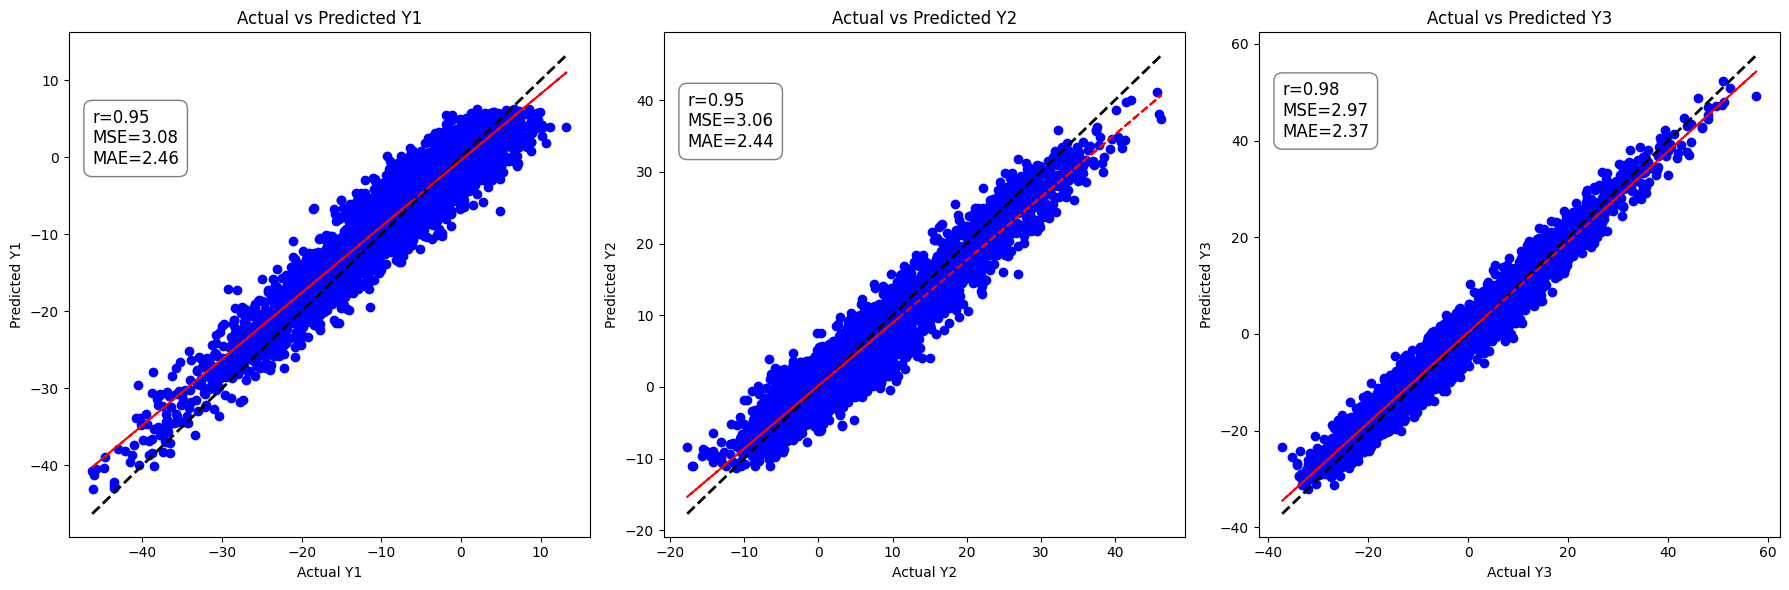

In [ ]:
plotgraph(y_test, y_pred)

##Regression - Q2##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = np.loadtxt('regression_data_multiGen_group_1_train.txt', skiprows=1)
np.random.shuffle(data)

In [ ]:
X = data[:,:2]
Y = data[:,2:]


In [ ]:
# Using the polynomial kernel [1 x1 x2 x1^2 x2^2 x1*x2]
phi_X =  np.c_[np.ones(X.shape[0]), X[:, 0], X[:, 1], X[:, 0]**2, X[:, 1]**2, X[:,0]*X[:,1]]

In [ ]:
X_train, X_test = phi_X[0:11000,:], phi_X[11000:,:]
print(f"X_train shape : {X_train.shape}\nX_test shape : {X_test.shape}")
Y_train, Y_test = Y[0:11000,:], Y[11000:,]
print(f"Y_train shape : {Y_train.shape}\nY_test shape : {Y_test.shape}")

X_train shape : (11000, 6)
X_test shape : (3000, 6)
Y_train shape : (11000, 3)
Y_test shape : (3000, 3)


In [ ]:
x_train = X_train.T
y_train = Y_train.T

In [ ]:

dims = [6, 16, 8, 3]
nn = NeuralNetwork(dims, 2000)
nn.train(x_train, y_train)

Iteration 0, RMSE: 22.473620987609998
Iteration 100, RMSE: 15.69086429981887
Iteration 200, RMSE: 14.460696210025118
Iteration 300, RMSE: 14.11791248629704
Iteration 400, RMSE: 13.94555462027171
Iteration 500, RMSE: 13.901594123460567
Iteration 600, RMSE: 12.205097198286154
Iteration 700, RMSE: 11.942206660034596
Iteration 800, RMSE: 10.116494367422902
Iteration 900, RMSE: 9.20839847906955
Iteration 1000, RMSE: 8.736953877893965
Iteration 1100, RMSE: 8.219664281660961
Iteration 1200, RMSE: 7.555021524045286
Iteration 1300, RMSE: 6.5158604096599575
Iteration 1400, RMSE: 6.0483656228061395
Iteration 1500, RMSE: 5.317087694228036
Iteration 1600, RMSE: 5.458006676763944
Iteration 1700, RMSE: 5.289352315691992
Iteration 1800, RMSE: 5.244334355806059
Iteration 1900, RMSE: 5.408200764332061


In [ ]:
x_test = X_test.T
y_test = Y_test.T

In [ ]:
Z_test, A_test = nn.forward_prop(x_test)
test_predictions = A_test['A' + str(nn.N - 1)]
test_mse = nn.compute_cost(A_test, y_test)
test_mae = nn.compute_mae(A_test, y_test)
test_pearson = nn.compute_pearson(A_test, y_test)

print("MSE:", test_mse)
print("MAE:", test_mae)
print("Pearson's correlation coefficient:", test_pearson)

MSE: 5.330634143891853
MAE: 2.464393316644234
Pearson's correlation coefficient: 0.9718232710859934


In [ ]:
y_pred = test_predictions.T
y_test = y_test.T


In [ ]:
y_test.shape

(3000, 3)

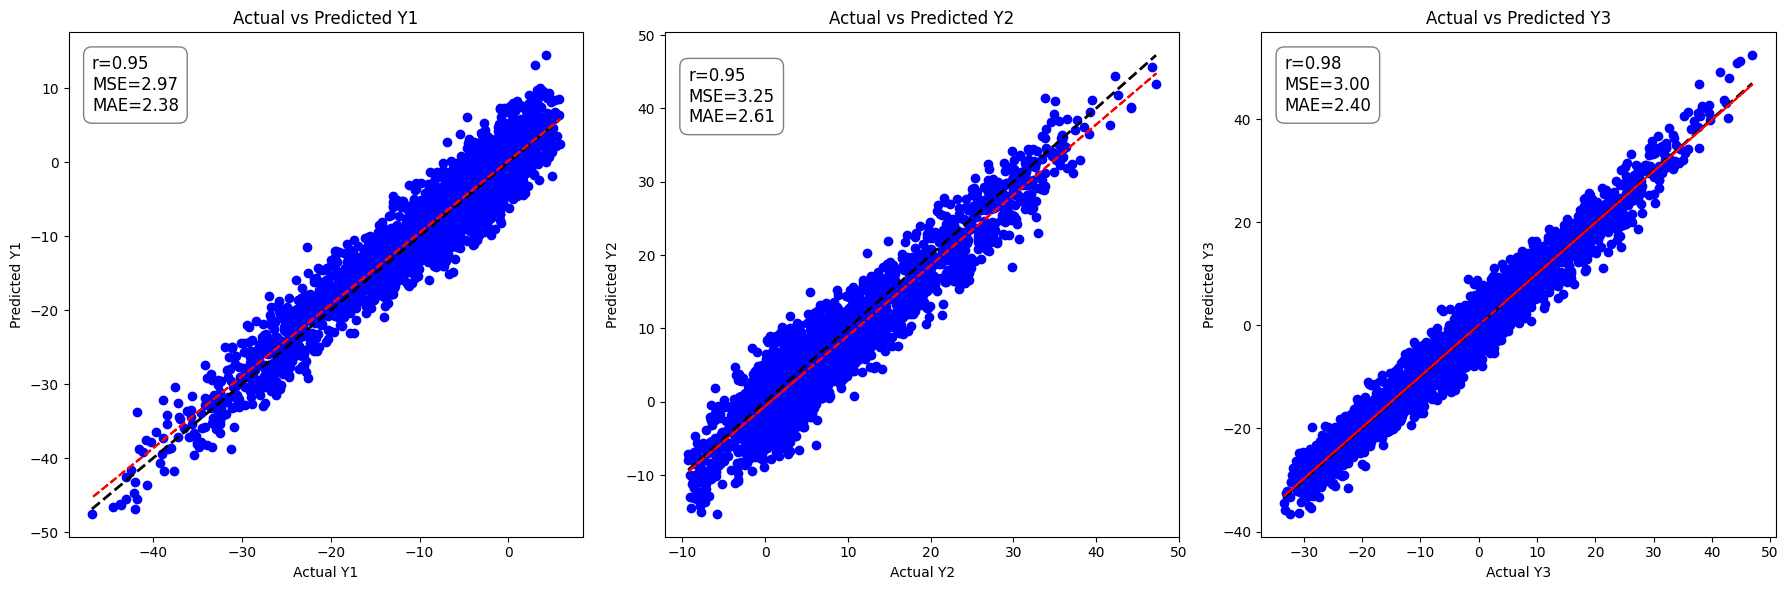

In [ ]:
plotgraph(y_pred, y_test)

## Regression Q3##

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data =np.loadtxt('regression_data_uni_group_1_train.txt' ,skiprows=1)

In [ ]:
data.shape

(7000, 6)

In [ ]:
x_data=data[:, :5]
y_data=data[:, 5:]

In [ ]:
n_samples = x_data.shape[0]
bias = np.ones((n_samples, 1))
x_data = np.concatenate([x_data, bias], axis=1)
x_data.shape

(7000, 6)

**Sigmoid Kernel**

In [ ]:
x_data_1=np.zeros(x_data.shape)
def sigmoid(x):
    return 100 / (1.0 + np.exp(-x))

for i in range(len(y_data)):
  for j in range(5):
    x_data_1[i][j]=sigmoid(x_data[i][j])

In [ ]:
x_data_1.shape

(7000, 6)

In [ ]:
x_data_train,x_data_test,y_data_train,y_data_test=x_data_1[:5000],x_data_1[5000:],y_data[:5000],y_data[5000:]
x_data_train.shape,x_data_test.shape,y_data_train.shape,y_data_test.shape

((5000, 6), (2000, 6), (5000, 1), (2000, 1))

In [ ]:
x_train = x_data_train.T
y_train = y_data_train.T

In [ ]:
dims = [6, 16, 8, 1]
nn = NeuralNetwork(dims, 1000)
nn.train(x_train, y_train)

Iteration 0, RMSE: 0.5702142646247123
Iteration 100, RMSE: 0.4135777017119414
Iteration 200, RMSE: 0.39354927526165756
Iteration 300, RMSE: 0.31200402613154404
Iteration 400, RMSE: 0.2592135085726852
Iteration 500, RMSE: 0.23847958405236022
Iteration 600, RMSE: 0.2238811678678247
Iteration 700, RMSE: 0.2134721058240782
Iteration 800, RMSE: 0.20745368531773653
Iteration 900, RMSE: 0.2044301816914557


In [ ]:
x_test = x_data_test.T
y_test = y_data_test.T

In [ ]:
Z_test, A_test = nn.forward_prop(x_test)
test_predictions = A_test['A' + str(nn.N - 1)]
test_mse = nn.compute_cost(A_test, y_test)
test_mae = nn.compute_mae(A_test, y_test)
test_pearson = nn.compute_pearson(A_test, y_test)

print("MSE:", test_mse)
print("MAE:", test_mae)
print("Pearson's correlation coefficient:", test_pearson)

MSE: 0.20583015868322424
MAE: 0.14568016054935862
Pearson's correlation coefficient: 0.863565350102567


In [ ]:
y_data_pred = test_predictions.T
y_data_test = y_test.T


In [ ]:
y_test.shape

(1, 2000)

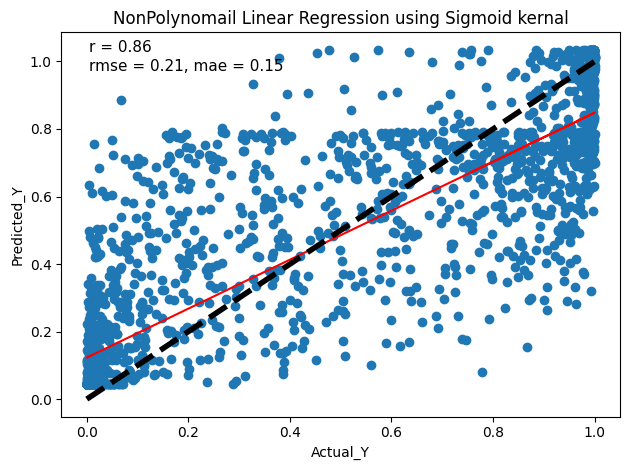

In [ ]:
def compute_best_fit_line(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
    intercept = y_mean - slope * x_mean
    return slope, intercept


correlation = np.corrcoef(y_data_test.T, y_data_pred.T)[0, 1]
rmse = np.sqrt(np.mean((y_data_test - y_data_pred) ** 2))
mae = np.mean(np.abs(y_data_test - y_data_pred))
plt.annotate(f'r = {correlation:.2f}',xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11)
plt.annotate(f'rmse = {rmse:.2f}, mae = {mae:.2f}',xy=(0.05, 0.9), xycoords='axes fraction', fontsize=11)
#Red Line (Best fit)
slope, intercept = compute_best_fit_line(y_data_test, y_data_pred)
plt.plot(y_data_test, slope * y_data_test + intercept, color='red')

#Black Line (Y=x line)
plt.plot([y_data_test.min(), y_data_test.max()], [y_data_test.min(), y_data_test.max()], 'k--', lw=4)
plt.scatter(y_data_test, y_data_pred, label='Data Points')

plt.title(f'NonPolynomail Linear Regression using Sigmoid kernal')
plt.xlabel('Actual_Y')
plt.ylabel('Predicted_Y')
plt.tight_layout()
plt.show()

**Gaussian Kernel**

In [ ]:
myu=np.mean(x_data,axis=1)

def gauss_kernel(x, myu, sigma):
    return 100*np.exp(-np.linalg.norm(x - myu)**2 / (2 * sigma**2))

x_data_3=np.zeros(x_data.shape)
for i in range(len(y_data)):
  for j in range(5):
    x_data_3[i][j]=gauss_kernel(x_data[i][j],myu[i],sigma=0.95)


x_data_train_3,x_data_test_3,y_data_train_3,y_data_test_3=x_data_3[:5000],x_data_3[5000:],y_data[:5000],y_data[5000:]

In [ ]:
x_train = x_data_train_3.T
y_train = y_data_train_3.T

In [ ]:
dims = [6, 16, 8, 1]
nn = NeuralNetwork(dims, 1000)
nn.train(x_train, y_train)

Iteration 0, RMSE: 0.569473445268636
Iteration 100, RMSE: 0.41152696919943893
Iteration 200, RMSE: 0.39289944338274285
Iteration 300, RMSE: 0.33399095832195863
Iteration 400, RMSE: 0.2949800575539279
Iteration 500, RMSE: 0.2711646177580135
Iteration 600, RMSE: 0.2677266324314147
Iteration 700, RMSE: 0.2617948454255324
Iteration 800, RMSE: 0.24920539075771564
Iteration 900, RMSE: 0.24021933721366748


In [ ]:
x_test = x_data_test_3.T
y_test = y_data_test_3.T

In [ ]:
Z_test, A_test = nn.forward_prop(x_test)
test_predictions = A_test['A' + str(nn.N - 1)]
test_mse = nn.compute_cost(A_test, y_test)
test_mae = nn.compute_mae(A_test, y_test)
test_pearson = nn.compute_pearson(A_test, y_test)

print("MSE:", test_mse)
print("MAE:", test_mae)
print("Pearson's correlation coefficient:", test_pearson)

MSE: 0.23709338228249327
MAE: 0.17780850137420628
Pearson's correlation coefficient: 0.8217838399735204


In [ ]:
y_data_pred_3 = test_predictions.T
y_data_test_3 = y_test.T

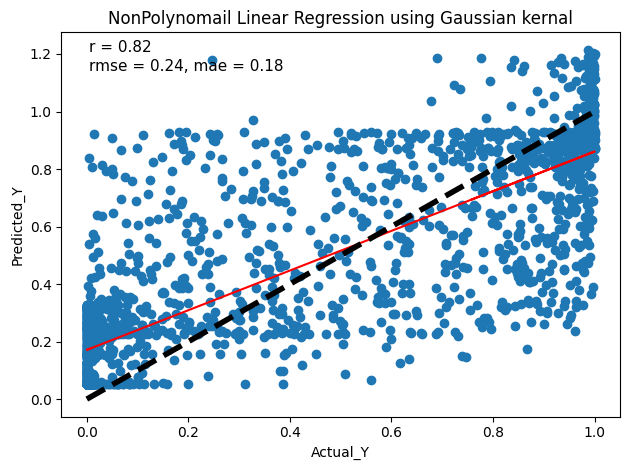

In [ ]:
corr_3 = np.corrcoef(y_data_test_3.T, y_data_pred_3.T)[0, 1]
rmse = np.sqrt(np.mean((y_data_test_3 - y_data_pred_3) ** 2))
mae = np.mean(np.abs(y_data_test_3 - y_data_pred_3))
plt.annotate(f'r = {corr_3:.2f}',xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11)
plt.annotate(f'rmse = {rmse:.2f}, mae = {mae:.2f}',xy=(0.05, 0.9), xycoords='axes fraction', fontsize=11)
#Red Line (Best fit)
slope, intercept = compute_best_fit_line(y_data_test_3, y_data_pred_3)
plt.plot(y_data_test, slope * y_data_test + intercept, color='red')

#Black Line (Y=x line)
plt.plot([y_data_test_3.min(), y_data_test_3.max()], [y_data_test_3.min(), y_data_test_3.max()], 'k--', lw=4)
plt.scatter(y_data_test_3, y_data_pred_3, label='Data Points')

plt.title(f'NonPolynomail Linear Regression using Gaussian kernal')
plt.xlabel('Actual_Y')
plt.ylabel('Predicted_Y')
plt.tight_layout()
plt.show()

**Exponential Kernel**

In [ ]:
def exponential(x, a, b):
    return 100*np.tan(np.arctan(a * np.exp(b * x)-0.5, dtype=np.float64))
    #return a * np.exp(b * x)

x_data_2=np.zeros(x_data.shape)
for i in range(len(y_data)):
  for j in range(5):
    x_data_2[i][j]=exponential(x_data[i][j],1.1,0.1)


x_data_train_2,x_data_test_2,y_data_train_2,y_data_test_2=x_data_2[:5000],x_data_2[5000:],y_data[:5000],y_data[5000:]

In [ ]:
x_train = x_data_train_2.T
y_train = y_data_train_2.T

In [ ]:
dims = [6, 16, 8, 1]
nn = NeuralNetwork(dims, 1000)
nn.train(x_train, y_train)

Iteration 0, RMSE: 0.569942052332232
Iteration 100, RMSE: 0.41240048882493824
Iteration 200, RMSE: 0.4091626179646769
Iteration 300, RMSE: 0.4044240814287879
Iteration 400, RMSE: 0.39395274191254126
Iteration 500, RMSE: 0.358727334076938
Iteration 600, RMSE: 0.2897569956990249
Iteration 700, RMSE: 0.26106687847661963
Iteration 800, RMSE: 0.2993541176887457
Iteration 900, RMSE: 0.2651797700000776


In [ ]:
x_test = x_data_test_2.T
y_test = y_data_test_2.T

In [ ]:
Z_test, A_test = nn.forward_prop(x_test)
test_predictions = A_test['A' + str(nn.N - 1)]
test_mse = nn.compute_cost(A_test, y_test)
test_mae = nn.compute_mae(A_test, y_test)
test_pearson = nn.compute_pearson(A_test, y_test)

print("MSE:", test_mse)
print("MAE:", test_mae)
print("Pearson's correlation coefficient:", test_pearson)

MSE: 0.2556000200994204
MAE: 0.20325451620224602
Pearson's correlation coefficient: 0.8160192090505164


In [ ]:
y_data_pred_2 = test_predictions.T
y_data_test_2 = y_test.T

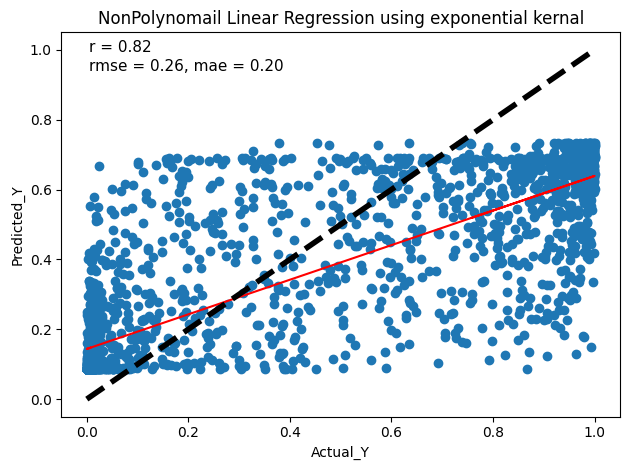

In [ ]:
corr_2 = np.corrcoef(y_data_test_2.T, y_data_pred_2.T)[0, 1]
rmse = np.sqrt(np.mean((y_data_test_2 - y_data_pred_2) ** 2))
mae = np.mean(np.abs(y_data_test_2 - y_data_pred_2))
plt.annotate(f'r = {corr_2:.2f}',xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11)
plt.annotate(f'rmse = {rmse:.2f}, mae = {mae:.2f}',xy=(0.05, 0.9), xycoords='axes fraction', fontsize=11)
#Red Line (Best fit)
slope, intercept = compute_best_fit_line(y_data_test_2, y_data_pred_2)
plt.plot(y_data_test, slope * y_data_test + intercept, color='red')

#Black Line (Y=x line)
plt.plot([y_data_test_2.min(), y_data_test_2.max()], [y_data_test_2.min(), y_data_test_2.max()], 'k--', lw=4)
plt.scatter(y_data_test_2, y_data_pred_2, label='Data Points')

plt.title(f'NonPolynomail Linear Regression using exponential kernal')
plt.xlabel('Actual_Y')
plt.ylabel('Predicted_Y')
plt.tight_layout()
plt.show()

## Q3: A) Classification Task of Assignment-1 using MLP

###(I) Binary Classification

####General Setup

In [ ]:
data=np.loadtxt('/content/drive/MyDrive/Colab Notebooks/binary_classification_data_group_0_train.txt',skiprows=1)

np.random.shuffle(data)
X_data=data[:,:-1]
Y_label=data[:,-1]

split_index=int(0.8*len(data))
train_X=X_data[0:split_index]
train_Y=Y_label[0:split_index]
test_X=X_data[split_index:]
test_Y=Y_label[split_index:]

train_X=normalize_data(train_X).T
test_X=normalize_data(test_X).T

In [ ]:
class NeuralNetwork_binary:
    def __init__(self, dims, alpha=0.01, iterations=1000):
        self.dims = dims
        self.alpha = alpha
        self.iterations = iterations
        self.N = len(dims)
        self.params = self.init_params()

    def init_params(self):
        params = {}
        np.random.seed(1127825)
        for i in range(1, self.N):
            params['W' + str(i)] = np.random.rand(self.dims[i], self.dims[i - 1]) - 0.5
            params['b' + str(i)] = np.random.rand(self.dims[i], 1) - 0.5
        return params

    @staticmethod
    def ReLU(Z):
        return np.maximum(Z, 0)

    @staticmethod
    def sigmoid(Z):
        return 1 / (1 + np.exp(-Z))

    @staticmethod
    def ReLU_deriv(Z):
        return Z > 0

    def forward_prop(self, X,par):
        Z = {}
        A = {}
        A['A0'] = X
        for i in range(1, self.N):
            Z['Z' + str(i)] = np.matmul(par['W' + str(i)], A['A' + str(i - 1)]) + par['b' + str(i)]
            if i != self.N - 1:
                A['A' + str(i)] = self.ReLU(Z['Z' + str(i)])
            else:
                A['A' + str(i)] = self.sigmoid(Z['Z' + str(i)])
        return Z, A

    def backward_prop(self, Z, A, X, Y):
        grads = {}
        m = X.shape[1]
        dZ = {}
        dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - Y)
        for i in range(self.N - 1, 0, -1):
            grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T)
            grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
            if i > 1:
                dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
        return grads

    def update_params(self, grads):
        for i in range(1, self.N):
            self.params['W' + str(i)] = self.params['W' + str(i)] - self.alpha * grads['dW' + str(i)]
            self.params['b' + str(i)] = self.params['b' + str(i)] - self.alpha * grads['db' + str(i)]
        return self.params

    @staticmethod
    def get_predictions(A2):
        return np.round(A2)

    @staticmethod
    def get_accuracy(predictions, Y):
        return np.sum(predictions == Y) / Y.size


    def predict(self,test_X,test_Y,par):
      z, a = self.forward_prop(test_X,par)
      pred= self.get_predictions(a['A' + str(self.N - 1)])
      acc=self.get_accuracy(pred, test_Y)*100
      acc=np.round(acc,2)
      return acc

    def compute_cost(self, A, Y):

      loss = np.where(np.round(A['A' + str(self.N - 1)]) != Y, 1, 0)
      return np.mean(loss)


    def train(self, X, Y,testX,testY):
        train_error_list=[]
        test_error_list=[]
        for i in range(self.iterations):
            _,test_A=self.forward_prop(testX,self.params)
            Z, A = self.forward_prop(X,self.params)
            grads = self.backward_prop(Z, A, X, Y)
            self.params = self.update_params(grads)
            test_cost=self.compute_cost(test_A,testY)
            train_cost=self.compute_cost(A,Y)
            train_error_list.append(train_cost)
            test_error_list.append(test_cost)
            if i % 50 == 0:
                if i==400:
                  self.alpha=0.01
                # print("\nIteration: ", i)
                predictions = self.get_predictions(A['A' + str(self.N - 1)])
                pred_test=self.get_predictions(test_A['A' + str(self.N - 1)])
                train_acc=np.round(self.get_accuracy(predictions, Y)*100,2)
                test_acc=np.round(self.get_accuracy(pred_test, testY)*100,2)
                print("\n Iteration: ",i,"    Training Accuracy: ",train_acc,"%     Test Accuracy: ",test_acc,"%")


        return self.params,train_error_list,test_error_list

#### 0-1 Loss (Without Regularization)

In [ ]:
def backward_prop01(self, Z, A, X, Y):
    grads = {}
    m = X.shape[1]
    dZ = {}
    dZ['dZ' + str(self.N - 1)] = (A['A' + str(self.N - 1)] >= 0.5).astype(int) - Y  # O-1 loss
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T)
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads


In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.01, 2000)
Model_binary.backward_prop=backward_prop01.__get__(Model_binary,NeuralNetwork_binary)
param,train_cost_list,test_cost_list=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.85 %     Test Accuracy:  50.96 %

 Iteration:  50     Training Accuracy:  62.8 %     Test Accuracy:  63.36 %

 Iteration:  100     Training Accuracy:  66.38 %     Test Accuracy:  66.21 %

 Iteration:  150     Training Accuracy:  68.74 %     Test Accuracy:  67.79 %

 Iteration:  200     Training Accuracy:  69.71 %     Test Accuracy:  68.14 %

 Iteration:  250     Training Accuracy:  70.43 %     Test Accuracy:  68.75 %

 Iteration:  300     Training Accuracy:  71.04 %     Test Accuracy:  68.86 %

 Iteration:  350     Training Accuracy:  71.48 %     Test Accuracy:  69.0 %

 Iteration:  400     Training Accuracy:  71.9 %     Test Accuracy:  69.29 %

 Iteration:  450     Training Accuracy:  72.11 %     Test Accuracy:  69.54 %

 Iteration:  500     Training Accuracy:  72.57 %     Test Accuracy:  69.54 %

 Iteration:  550     Training Accuracy:  72.9 %     Test Accuracy:  70.0 %

 Iteration:  600     Training Accuracy:  73.11 %     Test Accuracy:  70

Find Accuracy on Test Data

In [ ]:
test_accuracy=Model_binary.predict(test_X, test_Y, param)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  72.82 %


In [ ]:
len(train_cost_list)

2000

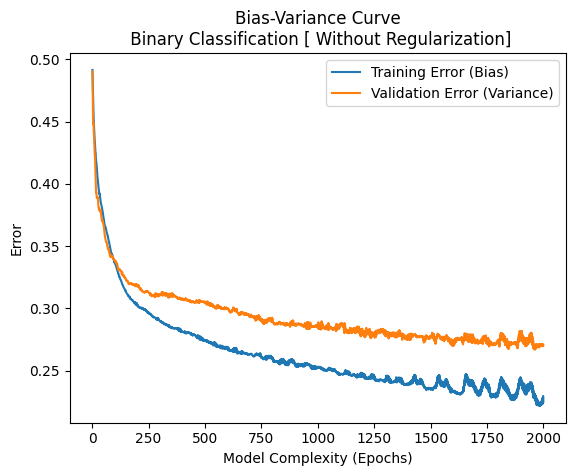

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\n Binary Classification [ Without Regularization]')
plt.legend()
plt.show()

#### 0-1 Loss (L1 Regularization)

In [ ]:
def backward_prop01(self, Z, A, X, Y):
    lambd=0.001
    grads = {}
    m = X.shape[1]
    dZ = {}
    dZ['dZ' + str(self.N - 1)] = (A['A' + str(self.N - 1)] >= 0.5).astype(int) - Y  # O-1 loss
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T)+ lambd * np.sign(self.params['W' + str(i)])
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads


In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.01, 2000)
Model_binary.backward_prop=backward_prop01.__get__(Model_binary,NeuralNetwork_binary)
param,train_cost_list,test_cost_list=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.85 %     Test Accuracy:  50.96 %

 Iteration:  50     Training Accuracy:  62.8 %     Test Accuracy:  63.39 %

 Iteration:  100     Training Accuracy:  66.38 %     Test Accuracy:  66.29 %

 Iteration:  150     Training Accuracy:  68.71 %     Test Accuracy:  67.71 %

 Iteration:  200     Training Accuracy:  69.75 %     Test Accuracy:  68.18 %

 Iteration:  250     Training Accuracy:  70.42 %     Test Accuracy:  68.82 %

 Iteration:  300     Training Accuracy:  71.04 %     Test Accuracy:  68.79 %

 Iteration:  350     Training Accuracy:  71.5 %     Test Accuracy:  69.0 %

 Iteration:  400     Training Accuracy:  71.82 %     Test Accuracy:  69.43 %

 Iteration:  450     Training Accuracy:  72.24 %     Test Accuracy:  69.32 %

 Iteration:  500     Training Accuracy:  72.64 %     Test Accuracy:  69.46 %

 Iteration:  550     Training Accuracy:  72.85 %     Test Accuracy:  69.93 %

 Iteration:  600     Training Accuracy:  73.04 %     Test Accuracy:  

Find Accuracy on Test Data

In [ ]:
test_accuracy=Model_binary.predict(test_X, test_Y, param)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  72.18 %


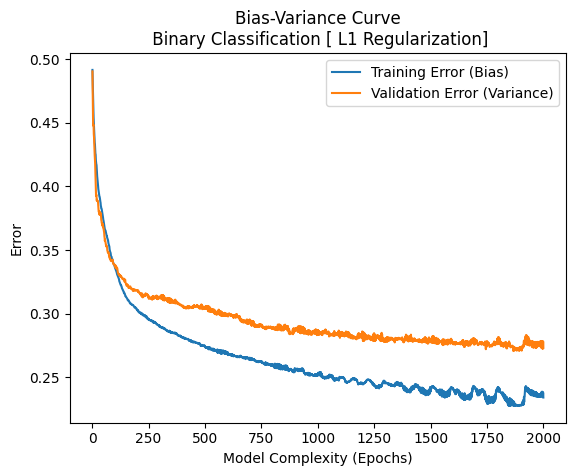

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\n Binary Classification [ L1 Regularization]')
plt.legend()
plt.show()

#### 0-1 Loss (L2 Regularization)

In [ ]:
def backward_prop01(self, Z, A, X, Y):
    lambd=0.01
    grads = {}
    m = X.shape[1]
    dZ = {}
    dZ['dZ' + str(self.N - 1)] = (A['A' + str(self.N - 1)] >= 0.5).astype(int) - Y  # O-1 loss
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads


In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.01, 2000)
Model_binary.backward_prop=backward_prop01.__get__(Model_binary,NeuralNetwork_binary)
param,train_cost_list,test_cost_list=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.85 %     Test Accuracy:  50.96 %

 Iteration:  50     Training Accuracy:  62.82 %     Test Accuracy:  63.43 %

 Iteration:  100     Training Accuracy:  66.31 %     Test Accuracy:  66.14 %

 Iteration:  150     Training Accuracy:  68.68 %     Test Accuracy:  67.75 %

 Iteration:  200     Training Accuracy:  69.8 %     Test Accuracy:  68.32 %

 Iteration:  250     Training Accuracy:  70.45 %     Test Accuracy:  68.68 %

 Iteration:  300     Training Accuracy:  70.99 %     Test Accuracy:  68.93 %

 Iteration:  350     Training Accuracy:  71.51 %     Test Accuracy:  69.0 %

 Iteration:  400     Training Accuracy:  71.69 %     Test Accuracy:  69.11 %

 Iteration:  450     Training Accuracy:  72.04 %     Test Accuracy:  69.25 %

 Iteration:  500     Training Accuracy:  72.55 %     Test Accuracy:  69.54 %

 Iteration:  550     Training Accuracy:  72.88 %     Test Accuracy:  69.68 %

 Iteration:  600     Training Accuracy:  73.07 %     Test Accuracy: 

Find Accuracy on Test Data

In [ ]:
test_accuracy=Model_binary.predict(test_X, test_Y, param)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  72.54 %


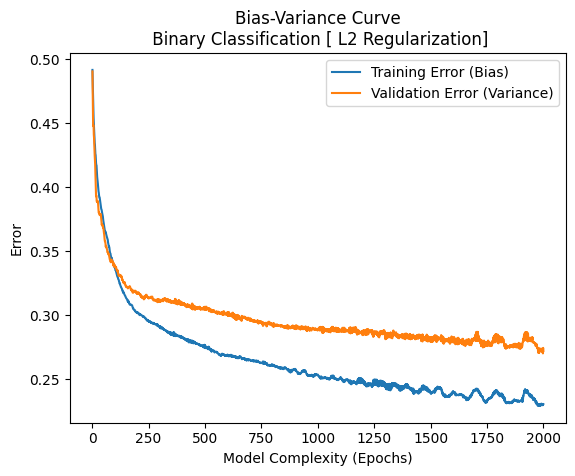

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\n Binary Classification [ L2 Regularization]')
plt.legend()
plt.show()

#### 0-1 Loss (Elastic Regularization)

In [ ]:
def backward_prop01(self, Z, A, X, Y):
    lambd1=0.001
    lambd2=0.001
    grads = {}
    m = X.shape[1]
    dZ = {}
    dZ['dZ' + str(self.N - 1)] = (A['A' + str(self.N - 1)] >= 0.5).astype(int) - Y  # O-1 loss
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd1 * np.sign(self.params['W' + str(i)]) + lambd2 * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads


In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.01, 2000)
Model_binary.backward_prop=backward_prop01.__get__(Model_binary,NeuralNetwork_binary)
param,train_cost_list,test_cost_list=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.57 %     Test Accuracy:  49.57 %

 Iteration:  50     Training Accuracy:  63.36 %     Test Accuracy:  63.07 %

 Iteration:  100     Training Accuracy:  66.7 %     Test Accuracy:  66.57 %

 Iteration:  150     Training Accuracy:  69.21 %     Test Accuracy:  68.75 %

 Iteration:  200     Training Accuracy:  70.5 %     Test Accuracy:  69.5 %

 Iteration:  250     Training Accuracy:  70.96 %     Test Accuracy:  70.07 %

 Iteration:  300     Training Accuracy:  71.42 %     Test Accuracy:  70.36 %

 Iteration:  350     Training Accuracy:  71.76 %     Test Accuracy:  70.54 %

 Iteration:  400     Training Accuracy:  72.16 %     Test Accuracy:  70.82 %

 Iteration:  450     Training Accuracy:  72.44 %     Test Accuracy:  70.89 %

 Iteration:  500     Training Accuracy:  72.61 %     Test Accuracy:  70.93 %

 Iteration:  550     Training Accuracy:  72.97 %     Test Accuracy:  71.14 %

 Iteration:  600     Training Accuracy:  72.93 %     Test Accuracy:  

Find Accuracy on Test Data

In [ ]:
test_accuracy=Model_binary.predict(test_X, test_Y, param)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  71.93 %


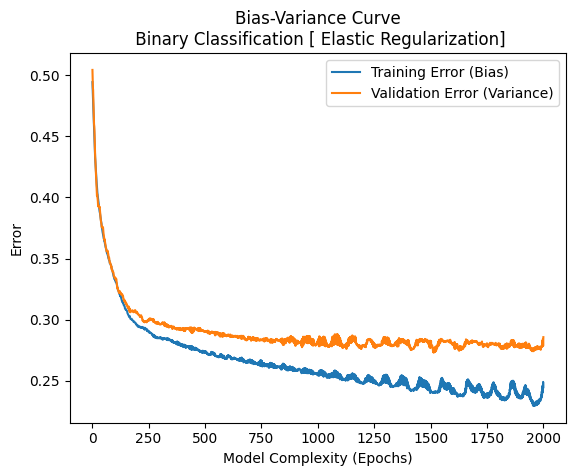

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\n Binary Classification [ Elastic Regularization]')
plt.legend()
plt.show()

#### Cross Entropy Loss(Without Regularization)

In [ ]:
def binary_cross_entropy_loss(self,A, y_true):
    n = len(y_true)
    y_pred=A['A' + str(self.N - 1)]
    loss = -1/n * (np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    return loss

def backward_prop_wr(self, Z, A, X, Y):
        grads = {}
        m = X.shape[1]
        dZ = {}
        dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - Y)
        for i in range(self.N - 1, 0, -1):
            grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T)
            grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
            if i > 1:
                dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
        return grads

In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.1, 2000)
Model_binary.compute_cost=binary_cross_entropy_loss.__get__(Model_binary, NeuralNetwork_binary)
Model_binary.backward_prop=backward_prop_wr.__get__(Model_binary, NeuralNetwork_binary)
param,train_error,test_error=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.57 %     Test Accuracy:  49.57 %

 Iteration:  50     Training Accuracy:  71.73 %     Test Accuracy:  72.32 %

 Iteration:  100     Training Accuracy:  77.29 %     Test Accuracy:  76.14 %

 Iteration:  150     Training Accuracy:  79.39 %     Test Accuracy:  77.46 %

 Iteration:  200     Training Accuracy:  80.75 %     Test Accuracy:  78.25 %

 Iteration:  250     Training Accuracy:  81.38 %     Test Accuracy:  78.43 %

 Iteration:  300     Training Accuracy:  81.81 %     Test Accuracy:  78.71 %

 Iteration:  350     Training Accuracy:  82.41 %     Test Accuracy:  78.86 %

 Iteration:  400     Training Accuracy:  82.9 %     Test Accuracy:  79.11 %

 Iteration:  450     Training Accuracy:  82.96 %     Test Accuracy:  79.14 %

 Iteration:  500     Training Accuracy:  83.0 %     Test Accuracy:  79.11 %

 Iteration:  550     Training Accuracy:  83.05 %     Test Accuracy:  79.11 %

 Iteration:  600     Training Accuracy:  83.09 %     Test Accuracy: 

In [ ]:
print("Final Test Accuracy: ",Model_binary.predict(test_X,test_Y,param),"%")

Final Test Accuracy:  79.21 %


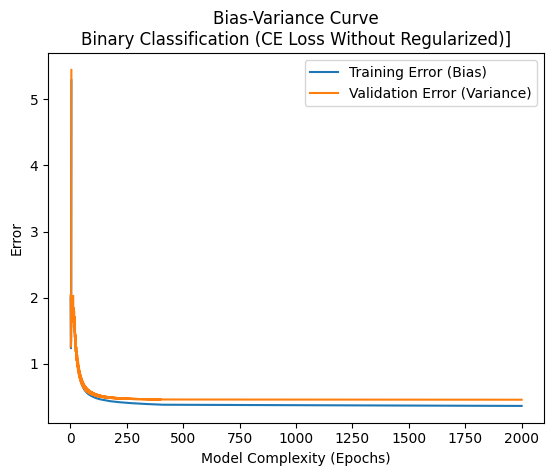

In [ ]:
training_errors = np.array(train_error)
validation_errors = np.array(test_error)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nBinary Classification (CE Loss Without Regularized)]')
plt.legend()
plt.show()

#### Cross Entropy Loss(L1 Regularization)

In [ ]:
def binary_cross_entropy_loss(self,A, y_true):
    n = len(y_true)
    y_pred=A['A' + str(self.N - 1)]
    loss = -1/n * (np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    return loss

def backward_prop_L1(self, Z, A, X, Y):
        lambd=0.001
        grads = {}
        m = X.shape[1]
        dZ = {}
        dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - Y)
        for i in range(self.N - 1, 0, -1):
            grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * np.sign(self.params['W' + str(i)])
            grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
            if i > 1:
                dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
        return grads

In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.01, 2000)
Model_binary.compute_cost=binary_cross_entropy_loss.__get__(Model_binary, NeuralNetwork_binary)
Model_binary.backward_prop=backward_prop_L1.__get__(Model_binary, NeuralNetwork_binary)
param,train_error,test_error=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.57 %     Test Accuracy:  49.57 %

 Iteration:  50     Training Accuracy:  64.01 %     Test Accuracy:  63.75 %

 Iteration:  100     Training Accuracy:  67.96 %     Test Accuracy:  67.93 %

 Iteration:  150     Training Accuracy:  70.91 %     Test Accuracy:  70.18 %

 Iteration:  200     Training Accuracy:  72.69 %     Test Accuracy:  71.57 %

 Iteration:  250     Training Accuracy:  73.82 %     Test Accuracy:  72.75 %

 Iteration:  300     Training Accuracy:  74.46 %     Test Accuracy:  73.39 %

 Iteration:  350     Training Accuracy:  75.04 %     Test Accuracy:  74.07 %

 Iteration:  400     Training Accuracy:  75.53 %     Test Accuracy:  74.32 %

 Iteration:  450     Training Accuracy:  75.96 %     Test Accuracy:  74.54 %

 Iteration:  500     Training Accuracy:  76.33 %     Test Accuracy:  74.75 %

 Iteration:  550     Training Accuracy:  76.71 %     Test Accuracy:  75.07 %

 Iteration:  600     Training Accuracy:  76.93 %     Test Accuracy

In [ ]:
print("Final Test Accuracy: ",Model_binary.predict(test_X,test_Y,param),"%")

Final Test Accuracy:  78.07 %


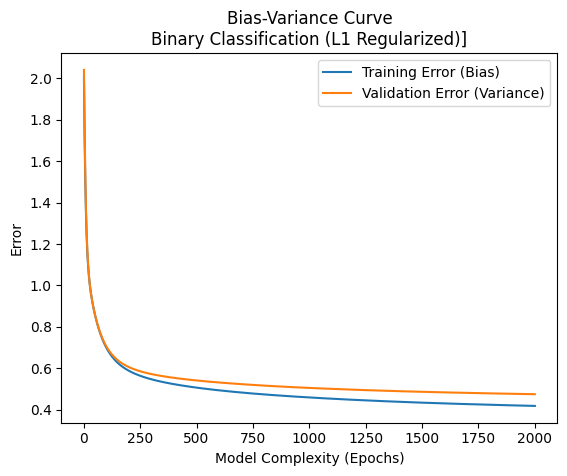

In [ ]:
training_errors = np.array(train_error)
validation_errors = np.array(test_error)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nBinary Classification (L1 Regularized)]')
plt.legend()
plt.show()

#### Cross Entropy Loss(L2 Regularization)

In [ ]:
def binary_cross_entropy_loss(self,A, y_true):

    n = len(y_true)
    y_pred=A['A' + str(self.N - 1)]
    loss = -1/n * (np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    return loss

def backward_prop_L2(self, Z, A, X, Y):
        lambd=0.01
        grads = {}
        m = X.shape[1]
        dZ = {}
        dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - Y)
        for i in range(self.N - 1, 0, -1):
            grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * self.params['W' + str(i)]
            grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
            if i > 1:
                dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
        return grads

In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.01, 2000)
Model_binary.compute_cost=binary_cross_entropy_loss.__get__(Model_binary, NeuralNetwork_binary)
Model_binary.backward_prop=backward_prop_L2.__get__(Model_binary, NeuralNetwork_binary)
param,train_cost_list,test_cost_list=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.57 %     Test Accuracy:  49.57 %

 Iteration:  50     Training Accuracy:  64.0 %     Test Accuracy:  63.75 %

 Iteration:  100     Training Accuracy:  67.88 %     Test Accuracy:  67.96 %

 Iteration:  150     Training Accuracy:  70.9 %     Test Accuracy:  70.18 %

 Iteration:  200     Training Accuracy:  72.81 %     Test Accuracy:  71.68 %

 Iteration:  250     Training Accuracy:  73.82 %     Test Accuracy:  72.89 %

 Iteration:  300     Training Accuracy:  74.62 %     Test Accuracy:  73.68 %

 Iteration:  350     Training Accuracy:  75.16 %     Test Accuracy:  74.21 %

 Iteration:  400     Training Accuracy:  75.66 %     Test Accuracy:  74.43 %

 Iteration:  450     Training Accuracy:  76.05 %     Test Accuracy:  74.89 %

 Iteration:  500     Training Accuracy:  76.38 %     Test Accuracy:  75.0 %

 Iteration:  550     Training Accuracy:  76.86 %     Test Accuracy:  75.29 %

 Iteration:  600     Training Accuracy:  77.23 %     Test Accuracy:  

In [ ]:
print("Final Test Accuracy: ",Model_binary.predict(test_X,test_Y,param),"%")

Final Test Accuracy:  78.0 %


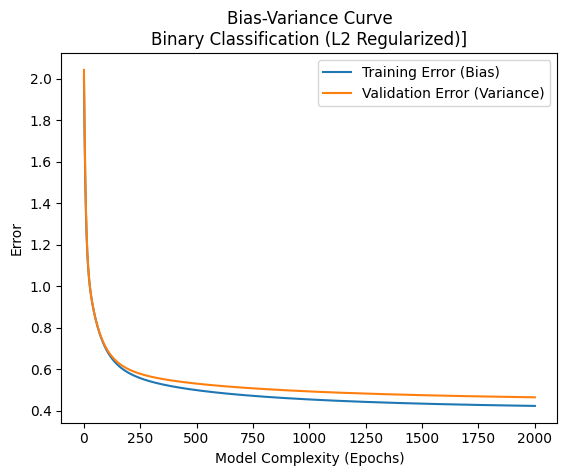

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nBinary Classification (L2 Regularized)]')
plt.legend()
plt.show()

#### Cross Entropy Loss(Elastic Regularization)

In [ ]:
def binary_cross_entropy_loss(self,A, y_true):
    n = len(y_true)
    y_pred=A['A' + str(self.N - 1)]
    loss = -1/n * (np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    return loss

def backward_prop_er(self, Z, A, X, Y):
        lambd1=0.001
        lambd2=0.001
        grads = {}
        m = X.shape[1]
        dZ = {}
        dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - Y)
        for i in range(self.N - 1, 0, -1):
            grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd1 * np.sign(self.params['W' + str(i)]) + lambd2 * self.params['W' + str(i)]
            grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
            if i > 1:
                dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
        return grads

In [ ]:
Model_binary=NeuralNetwork_binary([10,200,200,1], 0.01, 2000)
Model_binary.compute_cost=binary_cross_entropy_loss.__get__(Model_binary, NeuralNetwork_binary)
Model_binary.backward_prop=backward_prop_er.__get__(Model_binary, NeuralNetwork_binary)
param,train_cost_list,test_cost_list=Model_binary.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  50.57 %     Test Accuracy:  49.57 %

 Iteration:  50     Training Accuracy:  64.02 %     Test Accuracy:  63.75 %

 Iteration:  100     Training Accuracy:  67.96 %     Test Accuracy:  67.93 %

 Iteration:  150     Training Accuracy:  70.92 %     Test Accuracy:  70.18 %

 Iteration:  200     Training Accuracy:  72.73 %     Test Accuracy:  71.64 %

 Iteration:  250     Training Accuracy:  73.79 %     Test Accuracy:  72.75 %

 Iteration:  300     Training Accuracy:  74.46 %     Test Accuracy:  73.43 %

 Iteration:  350     Training Accuracy:  75.09 %     Test Accuracy:  74.11 %

 Iteration:  400     Training Accuracy:  75.54 %     Test Accuracy:  74.39 %

 Iteration:  450     Training Accuracy:  75.96 %     Test Accuracy:  74.57 %

 Iteration:  500     Training Accuracy:  76.34 %     Test Accuracy:  74.82 %

 Iteration:  550     Training Accuracy:  76.71 %     Test Accuracy:  75.11 %

 Iteration:  600     Training Accuracy:  76.94 %     Test Accuracy

In [ ]:
print("Final Test Accuracy: ",Model_binary.predict(test_X,test_Y,param),"%")

Final Test Accuracy:  78.14 %


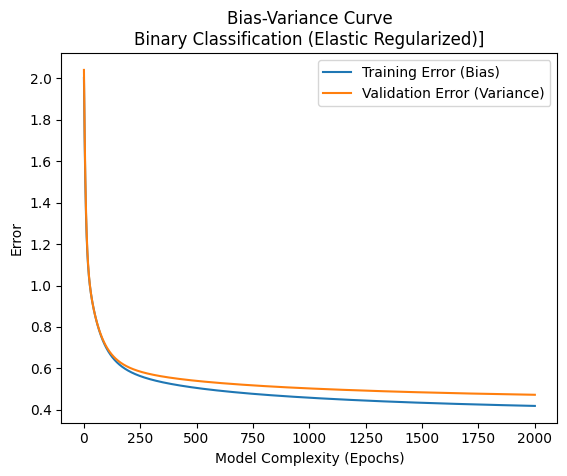

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nBinary Classification (Elastic Regularized)]')
plt.legend()
plt.show()

### (II) Multiclass Classification

####Data_setup

In [ ]:
def KL_divergence_loss(self, A, Y):

    m = Y.shape[0]
    scores = A['A' + str(self.N - 1)]
    softmax_scores = np.exp(scores) / np.sum(np.exp(scores), axis=0)

    one_hot_Y = np.zeros_like(scores)
    one_hot_Y[Y, np.arange(m)] = 1
    loss = -1. / m * np.sum(one_hot_Y * np.log(softmax_scores))

    return loss

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=np.loadtxt('/content/drive/MyDrive/Colab Notebooks/multi_class_classification_data_group_0_train.txt',skiprows=1)

In [ ]:
np.random.shuffle(data)
X_data=data[:,:-1]
Y_label=data[:,-1]

In [ ]:
split_index=int(0.8*len(data))
train_X=X_data[0:split_index]
train_Y=Y_label[0:split_index].astype('int')
test_X=X_data[split_index:]
test_Y=Y_label[split_index:].astype('int')

train_X=normalize_data(train_X).T
test_X=normalize_data(test_X).T

#### KL divergence Loss(Without Regularization)

In [ ]:
def backward_prop_KL(self, Z, A, X, Y):
    grads = {}
    m = X.shape[1]

    dZ = {}

    scores = A['A' + str(self.N - 1)]
    softmax_scores = np.exp(scores) / np.sum(np.exp(scores), axis=0)

    one_hot_Y = np.zeros_like(scores)
    one_hot_Y[Y, np.arange(m)] = 1

    dZ['dZ' + str(self.N - 1)] = softmax_scores - one_hot_Y

    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T)
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])

    return grads

In [ ]:
Model_multi_KL=NeuralNetwork_1([25,300,10], 0.01, 2000)
Model_multi_KL.backward_prop=backward_prop_KL.__get__(Model_multi_KL,NeuralNetwork_1)
Model_multi_KL.compute_cost=KL_divergence_loss.__get__(Model_multi_KL, NeuralNetwork_1)
multi_par,train_cost_list,test_cost_list=Model_multi_KL.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.06 %    Test Accuracy:  9.22 %

 Iteration:  20     Training Accuracy:  9.72 %    Test Accuracy:  9.8 %

 Iteration:  40     Training Accuracy:  10.47 %    Test Accuracy:  10.55 %

 Iteration:  60     Training Accuracy:  11.3 %    Test Accuracy:  11.44 %

 Iteration:  80     Training Accuracy:  12.26 %    Test Accuracy:  12.36 %

 Iteration:  100     Training Accuracy:  13.27 %    Test Accuracy:  13.31 %

 Iteration:  120     Training Accuracy:  14.31 %    Test Accuracy:  14.25 %

 Iteration:  140     Training Accuracy:  15.33 %    Test Accuracy:  15.43 %

 Iteration:  160     Training Accuracy:  16.33 %    Test Accuracy:  16.39 %

 Iteration:  180     Training Accuracy:  17.29 %    Test Accuracy:  17.36 %

 Iteration:  200     Training Accuracy:  18.33 %    Test Accuracy:  18.19 %

 Iteration:  220     Training Accuracy:  19.25 %    Test Accuracy:  19.02 %

 Iteration:  240     Training Accuracy:  20.21 %    Test Accuracy:  19.99 %

 Iteration

In [ ]:
test_accuracy=Model_multi_KL.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

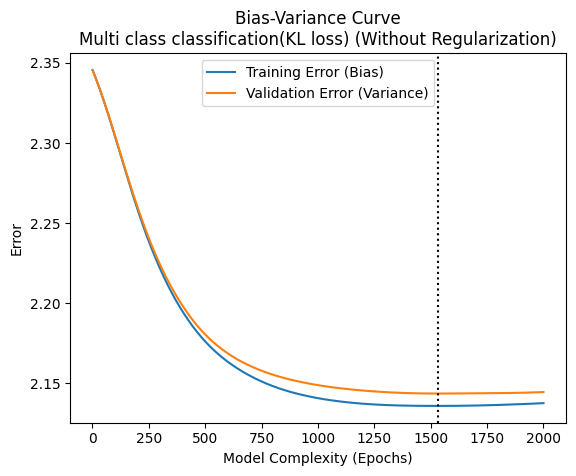

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))
plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.axvline(x=np.argmin(validation_errors), color='black', linestyle='dotted')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nMulti class classification(KL loss) (Without Regularization)')
plt.legend()
plt.show()

#### KL divergence Loss (L1 Regularization)

In [ ]:
def backward_prop_KL_L1(self, Z, A, X, Y):

    lambd=0.0001
    grads = {}
    m = X.shape[1]

    # Initialize the dZ dictionary
    dZ = {}

    # Compute the derivative of the KL divergence loss
    scores = A['A' + str(self.N - 1)]
    softmax_scores = np.exp(scores) / np.sum(np.exp(scores), axis=0)

    # Create a one-hot encoded version of Y
    one_hot_Y = np.zeros_like(scores)
    one_hot_Y[Y, np.arange(m)] = 1

    dZ['dZ' + str(self.N - 1)] = softmax_scores - one_hot_Y

    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * np.sign(self.params['W' + str(i)])
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])

    return grads


In [ ]:
Model_multi_KL=NeuralNetwork_1([25,300,10], 0.01, 2000)
Model_multi_KL.backward_prop=backward_prop_KL_L1.__get__(Model_multi_KL,NeuralNetwork_1)
Model_multi_KL.compute_cost=KL_divergence_loss.__get__(Model_multi_KL, NeuralNetwork_1)
multi_par,train_cost_list,test_cost_list=Model_multi_KL.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.06 %    Test Accuracy:  9.22 %

 Iteration:  20     Training Accuracy:  9.72 %    Test Accuracy:  9.8 %

 Iteration:  40     Training Accuracy:  10.47 %    Test Accuracy:  10.55 %

 Iteration:  60     Training Accuracy:  11.3 %    Test Accuracy:  11.44 %

 Iteration:  80     Training Accuracy:  12.26 %    Test Accuracy:  12.35 %

 Iteration:  100     Training Accuracy:  13.27 %    Test Accuracy:  13.31 %

 Iteration:  120     Training Accuracy:  14.31 %    Test Accuracy:  14.26 %

 Iteration:  140     Training Accuracy:  15.32 %    Test Accuracy:  15.44 %

 Iteration:  160     Training Accuracy:  16.33 %    Test Accuracy:  16.38 %

 Iteration:  180     Training Accuracy:  17.29 %    Test Accuracy:  17.36 %

 Iteration:  200     Training Accuracy:  18.33 %    Test Accuracy:  18.19 %

 Iteration:  220     Training Accuracy:  19.24 %    Test Accuracy:  19.04 %

 Iteration:  240     Training Accuracy:  20.21 %    Test Accuracy:  19.99 %

 Iteration

In [ ]:
test_accuracy=Model_multi_KL.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  31.28 %


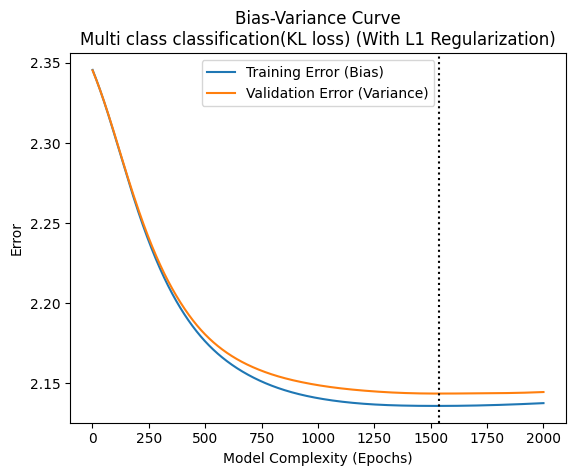

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))
plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.axvline(x=np.argmin(validation_errors), color='black', linestyle='dotted')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nMulti class classification(KL loss) (With L1 Regularization)')
plt.legend()
plt.show()

#### KL divergence Loss(L2 Regularization)

In [ ]:
def backward_prop_KL_L2(self, Z, A, X, Y):

    lambd=0.01
    grads = {}
    m = X.shape[1]

    # Initialize the dZ dictionary
    dZ = {}

    # Compute the derivative of the KL divergence loss
    scores = A['A' + str(self.N - 1)]
    softmax_scores = np.exp(scores) / np.sum(np.exp(scores), axis=0)

    # Create a one-hot encoded version of Y
    one_hot_Y = np.zeros_like(scores)
    one_hot_Y[Y, np.arange(m)] = 1

    dZ['dZ' + str(self.N - 1)] = softmax_scores - one_hot_Y

    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])

    return grads


In [ ]:
Model_multi_KL=NeuralNetwork_1([25,300,10], 0.01, 2000)
Model_multi_KL.backward_prop=backward_prop_KL_L2.__get__(Model_multi_KL,NeuralNetwork_1)
Model_multi_KL.compute_cost=KL_divergence_loss.__get__(Model_multi_KL, NeuralNetwork_1)
multi_par,train_cost_list,test_cost_list=Model_multi_KL.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.06 %    Test Accuracy:  9.22 %

 Iteration:  20     Training Accuracy:  9.72 %    Test Accuracy:  9.8 %

 Iteration:  40     Training Accuracy:  10.48 %    Test Accuracy:  10.54 %

 Iteration:  60     Training Accuracy:  11.3 %    Test Accuracy:  11.42 %

 Iteration:  80     Training Accuracy:  12.26 %    Test Accuracy:  12.35 %

 Iteration:  100     Training Accuracy:  13.27 %    Test Accuracy:  13.31 %

 Iteration:  120     Training Accuracy:  14.29 %    Test Accuracy:  14.24 %

 Iteration:  140     Training Accuracy:  15.31 %    Test Accuracy:  15.46 %

 Iteration:  160     Training Accuracy:  16.32 %    Test Accuracy:  16.38 %

 Iteration:  180     Training Accuracy:  17.28 %    Test Accuracy:  17.36 %

 Iteration:  200     Training Accuracy:  18.32 %    Test Accuracy:  18.15 %

 Iteration:  220     Training Accuracy:  19.25 %    Test Accuracy:  19.06 %

 Iteration:  240     Training Accuracy:  20.22 %    Test Accuracy:  19.99 %

 Iteration

In [ ]:
test_accuracy=Model_multi_KL.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

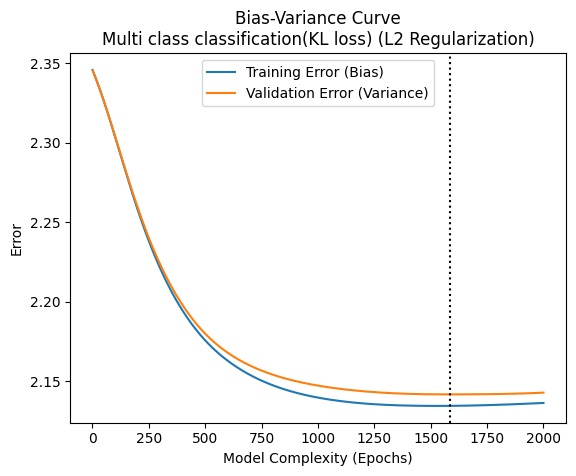

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.axvline(x=np.argmin(validation_errors), color='black', linestyle='dotted')
plt.title('Bias-Variance Curve\nMulti class classification(KL loss) (L2 Regularization)')
plt.legend()
plt.show()

#### KL divergence Loss(Elastic Regularization)

In [ ]:
def backward_prop_KL_er(self, Z, A, X, Y):

    lambd1=0.01
    lambd2=0.01
    grads = {}
    m = X.shape[1]
    dZ = {}

    scores = A['A' + str(self.N - 1)]
    softmax_scores = np.exp(scores) / np.sum(np.exp(scores), axis=0)
    one_hot_Y = np.zeros_like(scores)
    one_hot_Y[Y, np.arange(m)] = 1

    dZ['dZ' + str(self.N - 1)] = softmax_scores - one_hot_Y

    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd1 * np.sign(self.params['W' + str(i)]) + lambd2 * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])

    return grads


In [ ]:
Model_multi_KL=NeuralNetwork_1([25,300,10], 0.01, 2000)
Model_multi_KL.backward_prop=backward_prop_KL_er.__get__(Model_multi_KL,NeuralNetwork_1)
Model_multi_KL.compute_cost=KL_divergence_loss.__get__(Model_multi_KL, NeuralNetwork_1)
multi_par,train_cost_list,test_cost_list=Model_multi_KL.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.06 %    Test Accuracy:  9.22 %

 Iteration:  20     Training Accuracy:  9.72 %    Test Accuracy:  9.79 %

 Iteration:  40     Training Accuracy:  10.45 %    Test Accuracy:  10.5 %

 Iteration:  60     Training Accuracy:  11.31 %    Test Accuracy:  11.34 %

 Iteration:  80     Training Accuracy:  12.24 %    Test Accuracy:  12.34 %

 Iteration:  100     Training Accuracy:  13.21 %    Test Accuracy:  13.19 %

 Iteration:  120     Training Accuracy:  14.23 %    Test Accuracy:  14.2 %

 Iteration:  140     Training Accuracy:  15.26 %    Test Accuracy:  15.26 %

 Iteration:  160     Training Accuracy:  16.32 %    Test Accuracy:  16.32 %

 Iteration:  180     Training Accuracy:  17.32 %    Test Accuracy:  17.2 %

 Iteration:  200     Training Accuracy:  18.26 %    Test Accuracy:  18.09 %

 Iteration:  220     Training Accuracy:  19.29 %    Test Accuracy:  19.03 %

 Iteration:  240     Training Accuracy:  20.17 %    Test Accuracy:  19.87 %

 Iteration:

In [ ]:
test_accuracy=Model_multi_KL.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

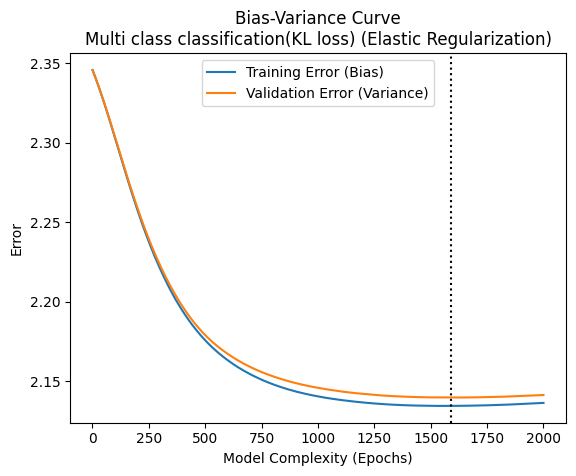

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))
plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.axvline(x=np.argmin(validation_errors), color='black', linestyle='dotted')
plt.title('Bias-Variance Curve\nMulti class classification(KL loss) (Elastic Regularization)')
plt.legend()
plt.show()

#### Cross Entropy Loss(Without Regularization)

In [ ]:
Model_multi_ce=NeuralNetwork_1([25,300,10], 2, 2000)
multi_par,train_cost_list,test_cost_list=Model_multi_ce.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.04 %    Test Accuracy:  9.23 %

 Iteration:  20     Training Accuracy:  39.52 %    Test Accuracy:  38.89 %

 Iteration:  40     Training Accuracy:  45.37 %    Test Accuracy:  43.86 %

 Iteration:  60     Training Accuracy:  48.11 %    Test Accuracy:  45.95 %

 Iteration:  80     Training Accuracy:  49.74 %    Test Accuracy:  46.98 %

 Iteration:  100     Training Accuracy:  50.95 %    Test Accuracy:  47.85 %

 Iteration:  120     Training Accuracy:  51.89 %    Test Accuracy:  48.34 %

 Iteration:  140     Training Accuracy:  51.22 %    Test Accuracy:  47.74 %

 Iteration:  160     Training Accuracy:  52.39 %    Test Accuracy:  48.81 %

 Iteration:  180     Training Accuracy:  53.21 %    Test Accuracy:  49.22 %

 Iteration:  200     Training Accuracy:  53.87 %    Test Accuracy:  49.71 %

 Iteration:  220     Training Accuracy:  54.32 %    Test Accuracy:  49.94 %

 Iteration:  240     Training Accuracy:  54.79 %    Test Accuracy:  50.39 %

 Itera

In [ ]:
test_accuracy=Model_multi_ce.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  54.92 %


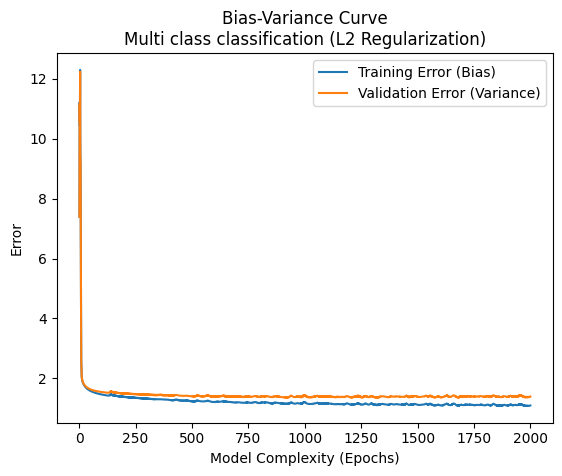

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nMulti class classification (L2 Regularization)')
plt.legend()
plt.show()

#### Cross Entropy Loss(With L1 Regularization)

In [ ]:
def backward_prop_L1(self,Z, A, X, Y):
    lambd=0.001
    grads = {}
    m = X.shape[1]
    one_hot_Y = self.one_hot(Y)
    dZ = {}
    dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - one_hot_Y)
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * np.sign(self.params['W' + str(i)])
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads

In [ ]:
Model_multi_ce=NeuralNetwork_1([25,300,10], 1, 2000)
Model_multi_ce.backward_prop=backward_prop_L1.__get__(Model_multi_ce,NeuralNetwork_1)
multi_par,train_cost_list,test_cost_list=Model_multi_ce.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.04 %    Test Accuracy:  9.23 %

 Iteration:  20     Training Accuracy:  30.5 %    Test Accuracy:  29.46 %

 Iteration:  40     Training Accuracy:  39.85 %    Test Accuracy:  38.65 %

 Iteration:  60     Training Accuracy:  44.41 %    Test Accuracy:  43.15 %

 Iteration:  80     Training Accuracy:  46.07 %    Test Accuracy:  44.59 %

 Iteration:  100     Training Accuracy:  47.01 %    Test Accuracy:  45.33 %

 Iteration:  120     Training Accuracy:  47.55 %    Test Accuracy:  46.26 %

 Iteration:  140     Training Accuracy:  47.88 %    Test Accuracy:  46.67 %

 Iteration:  160     Training Accuracy:  48.18 %    Test Accuracy:  47.11 %

 Iteration:  180     Training Accuracy:  48.48 %    Test Accuracy:  47.44 %

 Iteration:  200     Training Accuracy:  48.63 %    Test Accuracy:  47.76 %

 Iteration:  220     Training Accuracy:  48.76 %    Test Accuracy:  47.95 %

 Iteration:  240     Training Accuracy:  49.01 %    Test Accuracy:  48.19 %

 Iterat

In [ ]:
test_accuracy=Model_multi_ce.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  51.84 %


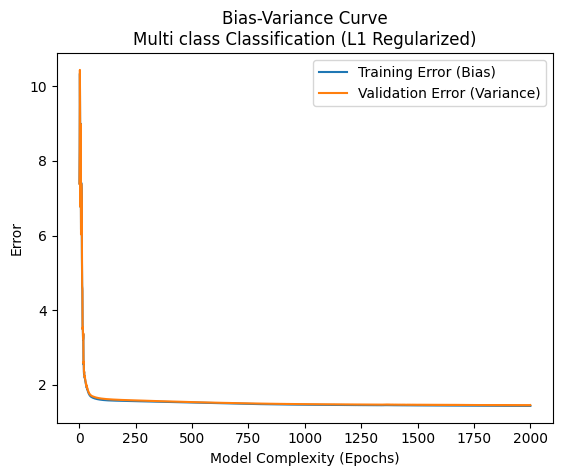

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nMulti class Classification (L1 Regularized)')
plt.legend()
plt.show()

#### Cross Entropy Loss(With L2 Regularization)

In [ ]:
def backward_prop_L2(self, Z, A, X, Y):
    lambd=0.001
    grads = {}
    m = X.shape[1]
    one_hot_Y = self.one_hot(Y)
    dZ = {}
    dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - one_hot_Y)
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads

In [ ]:
Model_multi_ce=NeuralNetwork_1([25,300,10], 1.5, 2000)
Model_multi_ce.backward_prop=backward_prop_L2.__get__(Model_multi_ce,NeuralNetwork_1)
multi_par,train_cost_list,test_cost_list=Model_multi_ce.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.04 %    Test Accuracy:  9.23 %

 Iteration:  20     Training Accuracy:  36.91 %    Test Accuracy:  36.4 %

 Iteration:  40     Training Accuracy:  44.02 %    Test Accuracy:  42.39 %

 Iteration:  60     Training Accuracy:  46.92 %    Test Accuracy:  44.75 %

 Iteration:  80     Training Accuracy:  48.43 %    Test Accuracy:  45.93 %

 Iteration:  100     Training Accuracy:  49.53 %    Test Accuracy:  46.76 %

 Iteration:  120     Training Accuracy:  50.37 %    Test Accuracy:  47.35 %

 Iteration:  140     Training Accuracy:  51.05 %    Test Accuracy:  47.92 %

 Iteration:  160     Training Accuracy:  51.64 %    Test Accuracy:  48.49 %

 Iteration:  180     Training Accuracy:  52.22 %    Test Accuracy:  49.04 %

 Iteration:  200     Training Accuracy:  52.72 %    Test Accuracy:  49.46 %

 Iteration:  220     Training Accuracy:  53.16 %    Test Accuracy:  49.72 %

 Iteration:  240     Training Accuracy:  53.47 %    Test Accuracy:  50.06 %

 Iterat

In [ ]:
test_accuracy=Model_multi_ce.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  57.44 %


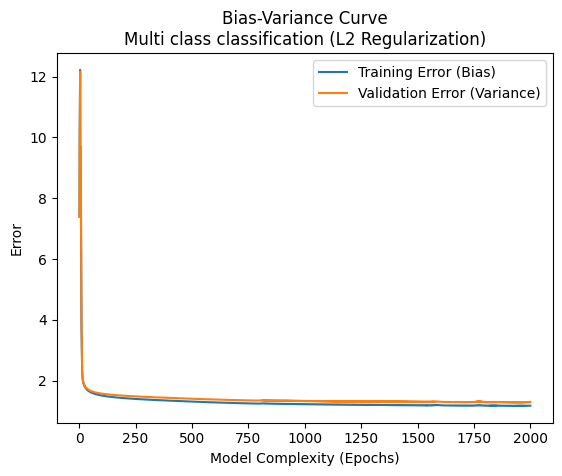

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\nMulti class classification (L2 Regularization)')
plt.legend()
plt.show()

#### Cross Entropy Loss(With Elatic Net Regularization)

In [ ]:
def backward_prop_elastic(self, Z, A, X, Y):
    lambd1=0.001
    lambd2=0.001
    grads = {}
    m = X.shape[1]
    one_hot_Y = self.one_hot(Y)
    dZ = {}
    dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - one_hot_Y)
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd1 * np.sign(self.params['W' + str(i)]) + lambd2 * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads

In [ ]:
Model_multi_ce=NeuralNetwork_1([25,300,10], 1, 2000)
Model_multi_ce.backward_prop=backward_prop_elastic.__get__(Model_multi_ce,NeuralNetwork_1)
multi_par,train_cost_list,test_cost_list=Model_multi_ce.train(train_X, train_Y,test_X,test_Y)


 Iteration:  0     Training Accuracy:  9.04 %    Test Accuracy:  9.23 %

 Iteration:  20     Training Accuracy:  28.04 %    Test Accuracy:  27.98 %

 Iteration:  40     Training Accuracy:  39.82 %    Test Accuracy:  39.4 %

 Iteration:  60     Training Accuracy:  44.37 %    Test Accuracy:  43.25 %

 Iteration:  80     Training Accuracy:  45.89 %    Test Accuracy:  44.36 %

 Iteration:  100     Training Accuracy:  46.73 %    Test Accuracy:  45.41 %

 Iteration:  120     Training Accuracy:  47.14 %    Test Accuracy:  45.96 %

 Iteration:  140     Training Accuracy:  47.29 %    Test Accuracy:  46.58 %

 Iteration:  160     Training Accuracy:  47.49 %    Test Accuracy:  46.69 %

 Iteration:  180     Training Accuracy:  47.66 %    Test Accuracy:  46.88 %

 Iteration:  200     Training Accuracy:  47.82 %    Test Accuracy:  47.06 %

 Iteration:  220     Training Accuracy:  47.79 %    Test Accuracy:  47.31 %

 Iteration:  240     Training Accuracy:  47.83 %    Test Accuracy:  47.23 %

 Iterat

In [ ]:
test_accuracy=Model_multi_ce.predict(test_X, test_Y, multi_par)
print('Testing Accuracy: ',test_accuracy,'%')

Testing Accuracy:  50.11 %


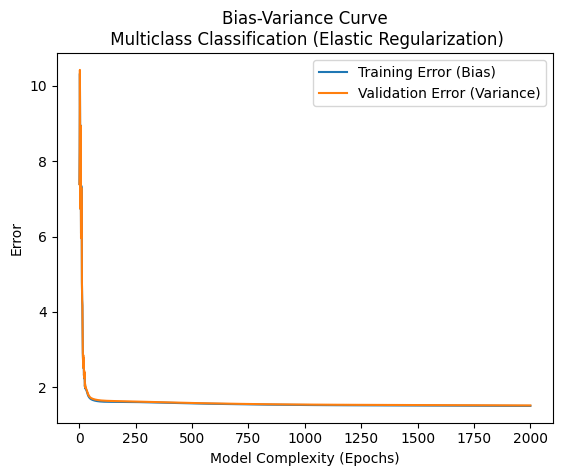

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve\n Multiclass Classification (Elastic Regularization)')
plt.legend()
plt.show()

# Q 3(b) SVM

## Basic Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt

# Installing libsvm
!pip install libsvm-official
from libsvm.svmutil import *

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for libsvm-official: filename=libsvm_official-3.32.0-cp310-cp310-linux_x86_64.whl size=123885 sha256=5f1b8ccda1f80b33b235ccb160a73afcdaab5679f0e0092984ff7d172829d25f
  Stored in directory: /root/.cache/pip/wheels/61/3b/1b/73bb4869517f96a26c82b47ccdb9ec48f12f4466de2371eff6
Successfully built libsvm-official


/usr/local/lib/python3.10/dist-packages/libsvm/svm.py:147: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def csr_to_problem_jit(l, x_val, x_ind, x_rowptr, prob_val, prob_ind, prob_rowptr, indx_start):


In [ ]:
!pip install qpsolvers
from qpsolvers import solve_qp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 2.7 MB/s eta 0:00:00


## 1.1 Binary Class SVM Using Optmization
--------------------------------------------------------

## **MAX_Margin_Classifier (SVM)**
* Construct the primal problem and find out largrangian $L(W,μ)$ and solve optmiztion problem and findout minimum value of **W** and lagrangion cofficient **μ** and put value of W in $L(W,μ)$ and then i will find out my Dual Function
$$$$
* $$
Dual\ Function:\ Q(μ)\ =\ \sum_{i=0}^{n} {μ_i}\ -\ 0.5*\sum_{i=0}^{n}\sum_{j=0}^{n} {μ_i}{μ_j}{y_i}{y_j}{X_i}^T{X_j}
$$
* $$
Dual\ Problem: max\ Q(μ)\ S.T.\ 0<=μ<=c\ \&\ \sum_{i=0}^{n} {μ_i}{y_i}\ =\ 0
$$
$$$$
* optmize above QP problem using SMO or QPSolver or we can also use directly LibSVM library for solve above problem


In [ ]:
# Load Data
data=np.loadtxt('/content/drive/My Drive/Prnn_data_group_1/binary_class_classification_data_group_0_train.txt',skiprows=1)
np.random.shuffle(data)
X,labels=data[:,:-1],data[:,-1]
labels = np.where(labels == 0, -1, 1)

In [ ]:
positives = np.sum(labels == 1)
negatives = np.sum(labels == -1)

if positives < 2000 or negatives < 2000:
    print("Warning: Not enough data points for balanced sampling. Using all available data.")
    sample_indices = np.random.choice(len(X), size=1000, replace=False)
else:
    positive_indices = np.random.choice(np.where(labels == 1)[0], size=2000, replace=False)
    negative_indices = np.random.choice(np.where(labels == -1)[0], size=2000, replace=False)

    sample_indices = np.concatenate((positive_indices, negative_indices))
    np.random.shuffle(sample_indices)

remaining_indices = np.setdiff1d(np.arange(len(data)), sample_indices)
np.random.shuffle(remaining_indices)
X_train= X[sample_indices]
y_train = labels[sample_indices]

X_val=X[remaining_indices[:5000]]
y_val=labels[remaining_indices[:5000]]
X_test = X[remaining_indices[5000:]]
y_test = labels[remaining_indices[5000:]]

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((4000, 10), (4000,), (5000, 10), (5000,), (5000, 10), (5000,))

In [ ]:
class BINARY_SVM():
  def __init__(self,X_train, X_test, y_train, y_test,input,C,degree=None,gamma=None):
    self.X_train=X_train
    self.y_train=y_train
    self.X_test=X_test
    self.y_test=y_test
    self.degree=degree
    self.gamma=gamma
    self.C=C
    self.input=input
    self.kernel=[self.linear_kernel, self.polynomial_kernel, self.rbf_kernel]
    return

  def linear_kernel(self,x1,x2):
    return np.dot(x1,x2.T)

  def polynomial_kernel(self,X1,X2):
    return (np.dot(X1, X2.T) + 1) ** self.degree

  def rbf_kernel(self,x1,x2):
    try:
      distance = np.linalg.norm(x1[:, None] - x2, axis=2) ** 2
    except:
      distance = np.linalg.norm(x1 - x2) ** 2
    return np.exp(-self.gamma * distance)

  def prediction(self):
    n_samples, n_features = self.X_train.shape
    K=self.kernel[self.input](self.X_train, self.X_train)
    P = np.outer(self.y_train, self.y_train) * K
    q = -np.ones(n_samples)
    G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
    h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C))
    A = self.y_train.reshape(1, -1).astype('d')
    b = np.zeros(1)
    mu = np.array(solve_qp(P, q, G, h ,A,b,solver='cvxopt')).flatten()

    support_vector_indices = np.where((mu > 1e-10) & (mu < self.C))
    X_support = self.X_train[support_vector_indices]
    y_support = self.y_train[support_vector_indices]
    mu_support = mu[support_vector_indices]

    w = np.sum(mu_support * y_support * X_support.T, axis=1)
    b = np.mean(y_support - np.dot(X_support, w))

    z = np.dot(self.X_test, w) + b
    y_pred = np.sign(z)
    accuracy = np.mean(y_pred == self.y_test)
    return accuracy * 100 , y_pred

## 1.1(a) Hard_BinaryClass_SVM_Using_Optmization
-----------------------------------------------------------

#### Linear_Kernel (Input=0)

In [ ]:
result=BINARY_SVM(X_train, X_val, y_train, y_val, input=0, C=100)
Accuracy , y_pred_Linear_HB_SVM = result.prediction()
print(f"Accuracy for Hard BinaryClass SVM  with Linear_kernel is on validation_data{Accuracy}%")
print(f"y_prediction 10 sample are {y_pred_Linear_HB_SVM[:10]}")

Accuracy for Hard BinaryClass SVM  with Linear_kernel is on validation_data69.24%
y_prediction 10 sample are [ 1. -1.  1. -1. -1. -1.  1. -1.  1.  1.]


In [ ]:
result=BINARY_SVM(X_train, X_test, y_train, y_test, input=0, C=100)
Accuracy , y_pred_Linear_HB_SVM = result.prediction()
print(f"Accuracy for Hard BinaryClass SVM  with Linear_kernel is on test_data{Accuracy}%")
print(f"y_prediction 10 sample are {y_pred_Linear_HB_SVM[:10]}")

Accuracy for Hard BinaryClass SVM  with Linear_kernel is on test_data68.38%
y_prediction 10 sample are [ 1. -1.  1.  1. -1.  1.  1.  1.  1. -1.]


#### Polynomial_kernel (Input=1)

In [ ]:
degree_values = np.linspace(1,5,2)
results_shape = (len(degree_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(degree_values):
    accuracy, y_pred_Poly_HB_SVM = BINARY_SVM(X_train, X_val, y_train, y_val, input=1, degree=param1_value, C=100).prediction()
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = degree_values[best_param1_idx]
print(f"Best parameters: Degree_of_polynomial = {best_param1}")
print(f"Accuracy for Hard BinaryClass SVM  with Polynomials _kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 10 sample are on validation data {y_pred_Poly_HB_SVM[:10]}")
print("")
print("TEST DATA")
print("")
result=BINARY_SVM(X_train, X_test, y_train, y_test, input=1, degree=best_param1, C=100)
Accuracy , y_pred_poly_HB_SVM = result.prediction()
print(f"Accuracy for Hard BinaryClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_poly_HB_SVM[:10]}")

Best parameters: Degree_of_polynomial = 1.0
Accuracy for Hard BinaryClass SVM  with Polynomials _kernel is on validation data67.92%
y_prediction 10 sample are on validation data [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

TEST DATA

Accuracy for Hard BinaryClass SVM  with Polynomial_kernel is on test_data 69.26%
y_prediction 10 sample are on test data [ 1.  1. -1.  1.  1.  1.  1.  1. -1. -1.]


#### RBF Kennel (Input=2)

In [ ]:
gamma_values = np.logspace(-3, 1, 5)
results_shape = (len(gamma_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    accuracy, y_pred_Poly_HB_SVM = BINARY_SVM(X_train, X_val, y_train, y_val, input=2, gamma=param1_value, C=100).prediction()
    results[param1_idx] = accuracy

best_param1_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
print(f"Best parameters: gamma_value of Rbf kernel = {best_param1}")
print(f"Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 10 sample are on validation data {y_pred_Poly_HB_SVM[:10]}")
print("")
print("TEST DATA")
print("")
result=BINARY_SVM(X_train, X_test, y_train, y_test, input=2, gamma=best_param1, C=100)
Accuracy , y_pred_rbf_HB_SVM = result.prediction()
print(f"Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_rbf_HB_SVM[:10]}")

Best parameters: gamma_value of Rbf kernel = 0.001
Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on validation data 67.72%
y_prediction 10 sample are on validation data [-1. -1.  1.  1.  1.  1. -1.  1.  1. -1.]

TEST DATA

Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on test_data 68.97999999999999%
y_prediction 10 sample are on test data [ 1.  1.  1.  1.  1. -1.  1.  1. -1. -1.]


## 1.1(b) SOFT_BinaryClass_SVM_Using_Optmization
------------------------------------------------------------

#### Linear_Kennel (Input=0)

In [ ]:
C_values = np.logspace(-2, 1, 5)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, y_pred_Poly_HB_SVM = BINARY_SVM(X_train, X_val, y_train, y_val, input=0, C=param1_value).prediction()
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft BinaryClass SVM  with Linear_kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 10 sample are on validation data {y_pred_Poly_HB_SVM[:10]}")
print("")
print("TEST DATA")
print("")
result=BINARY_SVM(X_train, X_test, y_train, y_test, input=0, C=best_param1)
Accuracy , y_pred_Linear_SB_SVM = result.prediction()
print(f"Accuracy for Soft BinaryClass SVM  with Linear_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_Linear_SB_SVM[:10]}")

Best parameters: C_parameter = 0.05623413251903491
Accuracy for Soft BinaryClass SVM  with Linear_kernel is on validation data68.10000000000001%
y_prediction 10 sample are on validation data [-1. -1.  1.  1.  1.  1. -1.  1.  1.  1.]

TEST DATA

Accuracy for Soft BinaryClass SVM  with Linear_kernel is on test_data 69.14%
y_prediction 10 sample are on test data [ 1.  1. -1.  1.  1.  1.  1.  1. -1. -1.]


#### Polynomial _Kennel With GridSearch (Input=1)

In [ ]:
Degree_values = np.linspace(1, 5, 5)
C_values = np.logspace(-2, 1, 5)
results_shape = (len(Degree_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(Degree_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = BINARY_SVM(X_train, X_val, y_train, y_val, input=1, degree=param1_value ,C=param2_value).prediction()
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = Degree_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft BinaryClass SVM  with Ploynomail kernel with GridSearch is {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=BINARY_SVM(X_train, X_test, y_train, y_test, input=1, degree=best_param1, C=best_param2)
Accuracy , y_pred_poly_SB_SVM = result.prediction()
print(f"Accuracy for Soft BinaryClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_poly_SB_SVM[:10]}")



Validation DATA

Best parameters: Degree_of_polynomial = 1.0, C_value = 0.05623413251903491
Accuracy for Soft BinaryClass SVM  with Ploynomail kernel with GridSearch is 68.54%

TEST DATA

Accuracy for Soft BinaryClass SVM  with Polynomial_kernel is on test_data 68.84%
y_prediction 10 sample are on test data [-1. -1.  1. -1. -1.  1.  1. -1.  1.  1.]


#### RBF Kennel With GridSearch (Input=2)

In [ ]:
gamma_values = np.logspace(-4, 0, 5)
C_values = np.logspace(-2, 1, 5)
results_shape = (len(gamma_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = BINARY_SVM(X_train, X_val, y_train, y_val, input=2, gamma=param1_value ,C=param2_value).prediction()
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Gamma_value in Rbf Kernel = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft BinaryClass SVM  with Rbf kernel with GridSearch is {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=BINARY_SVM(X_train, X_test, y_train, y_test, input=2, gamma=best_param1, C=best_param2)
Accuracy , y_pred_rbf_SB_SVM = result.prediction()
print(f"Accuracy for Soft BinaryClass SVM  with rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_rbf_SB_SVM[:10]}")


Validation DATA

Best parameters: Gamma_value in Rbf Kernel = 0.001, C_value = 10.0
Accuracy for Soft BinaryClass SVM  with Rbf kernel with GridSearch is 68.78%

TEST DATA

Accuracy for Soft BinaryClass SVM  with rbf_kernel is on test_data 68.66%
y_prediction 10 sample are on test data [-1. -1. -1. -1.  1. -1. -1.  1.  1.  1.]


## 1.2 Multi Class SVM Using Optmization
------------------------------------------------------

In [ ]:
#Load Data
Multiclass_data=np.loadtxt('/content/drive/My Drive/Prnn_data_group_1/multi_class_classification_data_group_0_train.txt',skiprows=1)
np.random.shuffle(Multiclass_data)
X_data,y_data=Multiclass_data[:,:-1],Multiclass_data[:,-1]
X_multi_train,y_multi_train=X_data[:2000],y_data[:2000]
X_multi_val,y_multi_val=X_data[2000:8000],y_data[2000:8000]
X_multi_test,y_multi_test=X_data[8000:],y_data[8000:]


X_multi_train.shape,y_multi_train.shape,X_multi_val.shape,y_multi_val.shape,X_multi_test.shape,y_multi_test.shape

((2000, 25), (2000,), (6000, 25), (6000,), (62000, 25), (62000,))

In [ ]:
class MULTI_SVM():
  def __init__(self, X_train, X_test, y_train, y_test, input, C, degree=None, gamma=None):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.degree = degree
    self.gamma = gamma
    self.C = C
    self.input = input
    self.kernel = [self.linear_kernel, self.polynomial_kernel, self.rbf_kernel]
    self.n_classes = 10

  def linear_kernel(self, x1, x2):
    return np.dot(x1, x2.T)

  def polynomial_kernel(self, X1, X2):
    return (np.dot(X1, X2.T) + 1) ** self.degree

  def rbf_kernel(self, x1, x2):
    try:
      distance = np.linalg.norm(x1[:, None] - x2, axis=2) ** 2
    except:
      distance = np.linalg.norm(x1 - x2) ** 2
    return np.exp(-self.gamma * distance)

  def prediction(self):
    n_samples, n_features = self.X_train.shape
    y_pred = np.zeros(len(self.y_test))
    for class_index in range(self.n_classes):
      y_train_binary = np.where(self.y_train == class_index, 1, -1)

      K = self.kernel[self.input](self.X_train, self.X_train)
      P = np.outer(y_train_binary, y_train_binary) * K
      q = -np.ones(n_samples)
      G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
      h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C))
      A = self.y_train.reshape(1, -1).astype('d')
      b = np.zeros(1)
      mu = np.array(solve_qp(P, q, G, h ,A,b,solver='cvxopt')).flatten()

      support_vector_indices = np.where((mu > 1e-10) & (mu < self.C))
      X_support = self.X_train[support_vector_indices]
      y_support = self.y_train[support_vector_indices]
      mu_support = mu[support_vector_indices]

      w = np.sum(mu_support * y_support * X_support.T, axis=1)
      b = np.mean(y_support - np.dot(X_support, w))

      z = np.dot(self.X_test, w) + b
      class_y_pred = np.sign(np.array(z))
      y_pred[class_y_pred == 1] = class_index

    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy * 100 , y_pred

## 1.2(a) Hard_MultiClass_SVM_Using_Optmization
------------------------------------------------------

#### Linear_kernel (Input=0)

In [ ]:
print("")
print("Validation Data")
print("")
model = MULTI_SVM(X_multi_train, X_multi_val, y_multi_train, y_multi_val, input=0, C=100)
Accuracy , y_pred_Linear_HM_SVM = model.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data {Accuracy}%")
print(f"y_prediction 20 sample are {y_pred_Linear_HM_SVM[:20]}")
print("")
print("Test Data")
print("")
model = MULTI_SVM(X_multi_train, X_multi_test, y_multi_train, y_multi_test, input=0, C=100)
Accuracy , y_pred_Linear_HM_SVM = model.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data {Accuracy}%")
print(f"y_prediction 20 sample are {y_pred_Linear_HM_SVM[:20]}")


Validation Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data9.857142857142858%
y_prediction 20 sample are [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Test Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data 10.043548387096775%
y_prediction 20 sample are [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### polynomial_kernel (Input=1)

In [ ]:
degree_values = np.linspace(0,5,6)
results_shape = (len(degree_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(degree_values):
    accuracy, y_pred_Poly_HM_SVM = MULTI_SVM(X_multi_train, X_multi_val, y_multi_train, y_multi_val, input=1, degree=param1_value, C=100).prediction()
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = degree_values[best_param1_idx]
print(f"Best parameters: Degree_of_polynomial = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM  with Polynomials _kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 20 sample are on validation data {y_pred_Poly_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(X_multi_train, X_multi_test, y_multi_train, y_multi_test, input=1, degree=best_param1, C=100)
Accuracy , y_pred_poly_HM_SVM = result.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_HM_SVM[:20]}")

Best parameters: Degree_of_polynomial = 0.0
Accuracy for Hard MultiClass SVM  with Polynomials _kernel is on validation data 9.8%
y_prediction 20 sample are on validation data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TEST DATA

Accuracy for Hard MultiClass SVM  with Polynomial_kernel is on test_data 10.06774193548387%
y_prediction 20 sample are on test data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Rbf_kernel (Input=2)

In [ ]:
gamma_values = np.logspace(-5, 0, 5)
results_shape = (len(gamma_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    accuracy, y_pred_rbf_HM_SVM = MULTI_SVM(X_multi_train, X_multi_val, y_multi_train, y_multi_val, input=2, gamma=param1_value, C=100).prediction()
    results[param1_idx] = accuracy

best_param1_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
print(f"Best parameters: gamma_value of Rbf kernel = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 20 sample are on validation data {y_pred_rbf_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(X_multi_train, X_multi_test, y_multi_train, y_multi_test, input=2, gamma=best_param1, C=100)
Accuracy , y_pred_rbf_HM_SVM = result.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_HM_SVM[:20]}")

Best parameters: gamma_value of Rbf kernel = 1e-05
Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data 9.916666666666666%
y_prediction 20 sample are on validation data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TEST DATA

Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data 10.058064516129033%
y_prediction 20 sample are on test data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 1.2(b) SOFT_MultiClass_SVM_Using_Optmization
-------------------------------------------------

#### Linear_kernel (Input=0)

In [ ]:
C_values = np.logspace(-3, 1, 10)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, y_pred_Linear_HM_SVM = MULTI_SVM(X_multi_train, X_multi_val, y_multi_train, y_multi_val,input=0, C=param1_value).prediction()
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {y_pred_Linear_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(X_multi_train, X_multi_test, y_multi_train, y_multi_test, input=0, C=best_param1)
Accuracy , y_pred_Linear_SM_SVM = result.prediction()
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_Linear_SM_SVM[:20]}")


Validation DATA

Best parameters: C_parameter = 0.05994842503189409
Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data 10.45%
y_prediction 20 sample are on validation data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TEST DATA

Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data 10.029032258064516%
y_prediction 20 sample are on test data [9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]


#### Polynomial_kernel with GridSearch (Input=1)

In [ ]:
Degree_values = [1,2,3]
C_values = np.logspace(-3, 1, 5)
results_shape = (len(Degree_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(Degree_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = MULTI_SVM(X_multi_train, X_multi_val, y_multi_train, y_multi_val, input=1, degree=param1_value ,C=param2_value).prediction()
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = Degree_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(X_multi_train, X_multi_test, y_multi_train, y_multi_test, input=1, degree=best_param1, C=best_param2)
Accuracy , y_pred_poly_SM_SVM = result.prediction()
print(f"Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_SM_SVM[:20]}")



Validation DATA

Best parameters: Degree_of_polynomial = 1, C_value = 0.01
Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data 10.383333333333333%

TEST DATA

Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data 10.04516129032258%
y_prediction 20 sample are on test data [9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]


#### RBF_kernel with GridSearch (Input=2)

In [ ]:
gamma_values = np.logspace(-5, 0, 5)
C_values = np.logspace(-3, 1, 5)
results_shape = (len(gamma_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = MULTI_SVM(X_multi_train, X_multi_val, y_multi_train, y_multi_val, input=2, gamma=param1_value ,C=param2_value).prediction()
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Gamma_value in Rbf Kernel = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(X_multi_train, X_multi_test, y_multi_train, y_multi_test, input=2, gamma=best_param1, C=best_param2)
Accuracy , y_pred_rbf_SM_SVM = result.prediction()
print(f"Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_SM_SVM[:20]}")


Validation DATA

Best parameters: Gamma_value in Rbf Kernel = 0.05623413251903491, C_value = 0.001
Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data 10.45%

TEST DATA

Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data 10.029032258064516%
y_prediction 20 sample are on test data [9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]


## 2.1 BinaryClass SVM Using LIBSVM
---------------------------------------

## 2.1(a) Hard BinaryClass SVM Using LIBSVM
------------------------------------

In [ ]:
class HARD_SVM():
  def __init__(self,X_train,X_test,y_train,y_test,c):
    self.X_train=X_train
    self.X_test=X_test
    self.y_train=y_train
    self.y_test=y_test
    self.c=c
    return
  def linear_kernal(self):
    train=svm_train(self.y_train,self.X_train, f'-t 0 -c {self.c}')
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy* 100, y_pred
  def poly_kernal(self,param1):
    train=svm_train(self.y_train,self.X_train, f'-t 1 -d {int(param1)} -c {self.c}')
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy*100, y_pred
  def Rbf_kernal(self, param1):
    train=svm_train(self.y_train,self.X_train, f'-t 2 -g {param1} -c {self.c}')
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy*100, y_pred
  def Sigmoid_kernal(self):
    train=svm_train(self.y_train,self.X_train, f'-t 3 -c {self.c}')
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy*100, y_pred


#### Linear Kernal

In [ ]:
print("")
print("Validation Data")
print("")
hard_margin=HARD_SVM(X_train,X_val,y_train,y_val,c=100)
Accuracy , y_pred_Linear_HB_SVM=hard_margin.linear_kernal()
print(f"Accuracy for Hard BinaryClass SVM  with Linear_kernel is on val_data {Accuracy}%")
print(f"y_prediction 10 sample are {y_pred_Linear_HB_SVM[:10]}")
print("")
print("Test Data")
print("")
hard_margin=HARD_SVM(X_train,X_test,y_train,y_test,c=100)
Accuracy , y_pred_Linear_HB_SVM=hard_margin.linear_kernal()
print(f"Accuracy for Hard BinaryClass SVM  with Linear_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are {y_pred_Linear_HB_SVM[:10]}")


Validation Data

Accuracy = 69.12% (3456/5000) (classification)
Accuracy for Hard BinaryClass SVM  with Linear_kernel is on val_data 69.12%
y_prediction 10 sample are [1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0]

Test Data

Accuracy = 68.58% (3429/5000) (classification)
Accuracy for Hard BinaryClass SVM  with Linear_kernel is on test_data 68.58%
y_prediction 10 sample are [-1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0]


#### Polynomial Kernal

In [ ]:
degree_values = np.linspace(1,5,2)
results_shape = (len(degree_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(degree_values):
    accuracy, y_pred_Poly_HB_SVM = HARD_SVM(X_train,X_val,y_train,y_val,c=100).poly_kernal(param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = degree_values[best_param1_idx]
print(f"Best parameters: Degree_of_polynomial = {best_param1}")
print(f"Accuracy for Hard BinaryClass SVM  with Polynomials _kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 10 sample are on validation data {y_pred_Poly_HB_SVM[:10]}")
print("")
print("TEST DATA")
print("")
result=HARD_SVM(X_train,X_test,y_train,y_test, c=100)
Accuracy , y_pred_poly_HB_SVM = result.poly_kernal(best_param1)
print(f"Accuracy for Hard BinaryClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_poly_HB_SVM[:10]}")

Accuracy = 69.08% (3454/5000) (classification)
Accuracy = 76.2% (3810/5000) (classification)
Best parameters: Degree_of_polynomial = 5.0
Accuracy for Hard BinaryClass SVM  with Polynomials _kernel is on validation data 76.2%
y_prediction 10 sample are on validation data [-1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0]

TEST DATA

Accuracy = 76.58% (3829/5000) (classification)
Accuracy for Hard BinaryClass SVM  with Polynomial_kernel is on test_data 76.58%
y_prediction 10 sample are on test data [1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0]


#### Rbf Kernal

In [ ]:
gamma_values = np.logspace(-3, 1, 5)
results_shape = (len(gamma_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    accuracy, y_pred_Poly_HB_SVM = HARD_SVM(X_train,X_val,y_train,y_val, c=100).Rbf_kernal(param1_value)
    results[param1_idx] = accuracy

best_param1_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
print(f"Best parameters: gamma_value of Rbf kernel = {best_param1}")
print(f"Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 10 sample are on validation data {y_pred_Poly_HB_SVM[:10]}")
print("")
print("TEST DATA")
print("")
result=HARD_SVM(X_train,X_test,y_train,y_test, c=100)
Accuracy , y_pred_rbf_HB_SVM = result.Rbf_kernal(best_param1)
print(f"Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_rbf_HB_SVM[:10]}")

Accuracy = 71.26% (3563/5000) (classification)
Accuracy = 77.32% (3866/5000) (classification)
Accuracy = 79.32% (3966/5000) (classification)
Accuracy = 77.6% (3880/5000) (classification)
Accuracy = 55.76% (2788/5000) (classification)
Best parameters: gamma_value of Rbf kernel = 0.1
Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on validation data 79.32000000000001%
y_prediction 10 sample are on validation data [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

TEST DATA

Accuracy = 79.3% (3965/5000) (classification)
Accuracy for Hard BinaryClass SVM  with Rbf_kernel is on test_data 79.3%
y_prediction 10 sample are on test data [-1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0]


#### Sigmoid Kernal

In [ ]:
print("")
print("Validation Data")
print("")
hard_margin=HARD_SVM(X_train,X_val,y_train,y_val,c=100)
Accuracy , y_pred_Linear_HB_SVM=hard_margin.Sigmoid_kernal()
print(f"Accuracy for Hard BinaryClass SVM  with Sigmoid_kernel is on val_data {Accuracy}%")
print(f"y_prediction 10 sample are {y_pred_Linear_HB_SVM[:10]}")
print("")
print("Test Data")
print("")
hard_margin=HARD_SVM(X_train,X_test,y_train,y_test,c=100)
Accuracy , y_pred_Linear_HB_SVM=hard_margin.Sigmoid_kernal()
print(f"Accuracy for Hard BinaryClass SVM  with Sigmoid_kernal is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are {y_pred_Linear_HB_SVM[:10]}")


Validation Data

Accuracy = 49.36% (2468/5000) (classification)
Accuracy for Hard BinaryClass SVM  with Sigmoid_kernel is on val_data 49.36%
y_prediction 10 sample are [1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0]

Test Data

Accuracy = 47.96% (2398/5000) (classification)
Accuracy for Hard BinaryClass SVM  with Sigmoid_kernal is on test_data 47.96%
y_prediction 10 sample are [1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 2.1(b) Soft BinaryClass SVM Using LIBSVM
-------------------------------------------------------------

*   C parameter controls regularization
*   Adjust C as needed


In [ ]:
class SOFT_SVM():
  def __init__(self,X_train,X_test,y_train,y_test):
    self.X_train=X_train
    self.X_test=X_test
    self.y_train=y_train
    self.y_test=y_test
    return

  def linear_kernal(self,C):
    train=svm_train(self.y_train,self.X_train, f'-t 0 -c {C}')
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy*100, y_pred

  def poly_kernal(self,degree,C):
    train=svm_train(self.y_train, self.X_train, f"-t 1 -d {int(degree)} -c {C}")
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy*100, y_pred

  def Rbf_kernal(self,gamma,C):
    train=svm_train(self.y_train,self.X_train, f"-t 2 -g {gamma} -c {C}")
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy*100, y_pred

  def Sigmoid_kernal(self,C):
    train=svm_train(self.y_train,self.X_train, f'-t 3 -c {C}')
    y_pred, _, _= svm_predict(self.y_test, self.X_test, train)
    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy*100, y_pred

#### Linear Kernal

In [ ]:
C_values = np.logspace(-2, 1, 5)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, y_pred_Poly_SB_SVM = SOFT_SVM(X_train, X_val, y_train, y_val,).linear_kernal(C=param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]
print("")
print("Find Best Parameters from Validation DATA")
print("")
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft BinaryClass SVM  with Linear_kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 20 sample are on validation data {y_pred_Poly_SB_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=SOFT_SVM(X_train, X_test, y_train, y_test)
Accuracy , y_pred_Linear_SB_SVM = result.linear_kernal(C=best_param1)
print(f"Accuracy for Soft BinaryClass SVM  with Linear_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_Linear_SB_SVM[:20]}")

Accuracy = 69.28% (3464/5000) (classification)
Accuracy = 69.08% (3454/5000) (classification)
Accuracy = 68.96% (3448/5000) (classification)
Accuracy = 68.98% (3449/5000) (classification)
Accuracy = 69% (3450/5000) (classification)

Find Best Parameters from Validation DATA

Best parameters: C_parameter = 0.01
Accuracy for Soft BinaryClass SVM  with Linear_kernel is on validation data 69.28%
y_prediction 20 sample are on validation data [-1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0]

TEST DATA

Accuracy = 68.52% (3426/5000) (classification)
Accuracy for Soft BinaryClass SVM  with Linear_kernel is on test_data 68.52000000000001%
y_prediction 20 sample are on test data [-1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]


#### Grid_Search Methode for finding best hyperparameters for Polynomial Kernal

In [ ]:
Degree_values = np.linspace(1, 5, 5)
C_values = np.logspace(-2, 1, 5)
results_shape = (len(Degree_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(Degree_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = SOFT_SVM(X_train, X_val, y_train, y_val).poly_kernal(degree=param1_value ,C=param2_value)
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = Degree_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Find Best Parameters from Validation DATA")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft BinaryClass SVM  with Ploynomail kernel with GridSearch is on Validation Data {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=SOFT_SVM(X_train, X_test, y_train, y_test)
Accuracy , y_pred_poly_SB_SVM = result.poly_kernal(degree=best_param1, C=best_param2)
print(f"Accuracy for Soft BinaryClass SVM  with Polynomial_kernel is on Test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_SB_SVM[:20]}")

Accuracy = 68.42% (3421/5000) (classification)
Accuracy = 69.1% (3455/5000) (classification)
Accuracy = 69.2% (3460/5000) (classification)
Accuracy = 69.06% (3453/5000) (classification)
Accuracy = 69.02% (3451/5000) (classification)
Accuracy = 67.66% (3383/5000) (classification)
Accuracy = 72.24% (3612/5000) (classification)
Accuracy = 74.2% (3710/5000) (classification)
Accuracy = 74.2% (3710/5000) (classification)
Accuracy = 74.4% (3720/5000) (classification)
Accuracy = 66.72% (3336/5000) (classification)
Accuracy = 71.28% (3564/5000) (classification)
Accuracy = 75.74% (3787/5000) (classification)
Accuracy = 77.64% (3882/5000) (classification)
Accuracy = 77.88% (3894/5000) (classification)
Accuracy = 66.76% (3338/5000) (classification)
Accuracy = 69.02% (3451/5000) (classification)
Accuracy = 74.44% (3722/5000) (classification)
Accuracy = 77.88% (3894/5000) (classification)
Accuracy = 77.7% (3885/5000) (classification)
Accuracy = 68.84% (3442/5000) (classification)
Accuracy = 66.92% (

#### Grid_Search Methode for finding best hyperparameters for Rbf Kernal

In [ ]:
gamma_values = np.logspace(-3, 1, 5)
C_values = np.logspace(-2, 1, 5)
results_shape = (len(gamma_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = SOFT_SVM(X_train, X_val, y_train, y_val).Rbf_kernal(gamma=param1_value ,C=param2_value)
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Find Best Parameters from Validation DATA")
print("")
print(f"Best parameters: Gamma_value in Rbf Kernel = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft BinaryClass SVM  with Rbf kernel with GridSearch is on Validation Data {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=SOFT_SVM(X_train, X_test, y_train, y_test)
Accuracy , y_pred_rbf_SB_SVM = result.Rbf_kernal(gamma=best_param1, C=best_param2)
print(f"Accuracy for Soft BinaryClass SVM  with rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 10 sample are on test data {y_pred_rbf_SB_SVM[:10]}")

Accuracy = 66.76% (3338/5000) (classification)
Accuracy = 66.76% (3338/5000) (classification)
Accuracy = 67.74% (3387/5000) (classification)
Accuracy = 68.9% (3445/5000) (classification)
Accuracy = 69.5% (3475/5000) (classification)
Accuracy = 67.7% (3385/5000) (classification)
Accuracy = 68.88% (3444/5000) (classification)
Accuracy = 69.74% (3487/5000) (classification)
Accuracy = 72.06% (3603/5000) (classification)
Accuracy = 74.94% (3747/5000) (classification)
Accuracy = 70.42% (3521/5000) (classification)
Accuracy = 73.46% (3673/5000) (classification)
Accuracy = 77.2% (3860/5000) (classification)
Accuracy = 78.62% (3931/5000) (classification)
Accuracy = 79.88% (3994/5000) (classification)
Accuracy = 71.28% (3564/5000) (classification)
Accuracy = 77.58% (3879/5000) (classification)
Accuracy = 77.6% (3880/5000) (classification)
Accuracy = 78.02% (3901/5000) (classification)
Accuracy = 76.22% (3811/5000) (classification)
Accuracy = 49.28% (2464/5000) (classification)
Accuracy = 49.28% 

#### Sigmoid Kernal

In [ ]:
C_values = np.logspace(-2, 1, 5)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, y_pred_sigmoid_SB_SVM = SOFT_SVM(X_train, X_val, y_train, y_val,).Sigmoid_kernal(C=param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]
print("")
print("Find Best Parameters from Validation DATA")
print("")
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft BinaryClass SVM with Sigmoid_kernal is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {y_pred_sigmoid_SB_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=SOFT_SVM(X_train, X_test, y_train, y_test)
Accuracy , y_pred_Linear_SB_SVM = result.Sigmoid_kernal(C=best_param1)
print(f"Accuracy for Soft BinaryClass SVM with Sigmoid_kernal is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_Linear_SB_SVM[:20]}")

Accuracy = 67.68% (3384/5000) (classification)
Accuracy = 65.74% (3287/5000) (classification)
Accuracy = 55.56% (2778/5000) (classification)
Accuracy = 49.46% (2473/5000) (classification)
Accuracy = 48.72% (2436/5000) (classification)

Find Best Parameters from Validation DATA

Best parameters: C_parameter = 0.01
Accuracy for Soft BinaryClass SVM  with Sigmoid_kernal is on validation data 67.67999999999999%
y_prediction 20 sample are on validation data [1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0]

TEST DATA

Accuracy = 66.36% (3318/5000) (classification)
Accuracy for Soft BinaryClass SVM  with Sigmoid_kernal is on test_data 66.36%
y_prediction 20 sample are on test data [-1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0]


## 2.2 MultiClass SVM Using LIBSVM
-------------------------------------------------------------------
#### ONE VS REST Methods
* For each class (0 to 9), create a binary classification problem
* Treat one class as the positive class and the rest as the negative class.
* Train a binary SVM model using LibSVM for that class.Repeat this process for all 10 classes.

In [ ]:
Multiclass_data=np.loadtxt('/content/drive/My Drive/Prnn_data_group_1/multi_class_classification_data_group_0_train.txt',skiprows=1)
np.random.shuffle(Multiclass_data)
X_data,y_data=Multiclass_data[:,:-1],Multiclass_data[:,-1]
X_multi_train,y_multi_train=X_data[:1000],y_data[:1000]
X_multi_val,y_multi_val=X_data[1000:8000],y_data[1000:8000]
X_multi_test,y_multi_test=X_data[8000:],y_data[8000:]


X_multi_train.shape,y_multi_train.shape,X_multi_val.shape,y_multi_val.shape,X_multi_test.shape,y_multi_test.shape

((1000, 25), (1000,), (7000, 25), (7000,), (62000, 25), (62000,))

In [ ]:
np.min(y_multi_train), np.max(y_multi_train) # that is i have 10 classes [0,1,2,3,4,5,6,7,8,9]

(0.0, 9.0)

## 2.2(a) Hard MultiClass SVM Using LIBSVM
----------------------------------------------------------

In [ ]:
class HARD_SVM_Multiclass():
  def __init__(self,X_multi_train,X_multi_test,y_multi_train,y_multi_test):
    self.X_multi_train=X_multi_train
    self.X_multi_test=X_multi_test
    self.y_multi_train=y_multi_train
    self.y_multi_test=y_multi_test
    return

  def Linear_kernal_multiClass(self):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 0 -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Poly_kernal_multiClass(self, degree):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 1 -d {int(degree)} -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Rbf_kernal_multiClass(self, gamma):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 2 -g {gamma} -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Sigmoid_kernal_multiClass(self):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 3 -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)

    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

#### Linear Kenal with MultiClass

In [ ]:
model = HARD_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val)
accuracy , Y_pred_Linear_HM_SVM = model.Linear_kernal_multiClass()

model = HARD_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_Linear_HM_SVM = model.Linear_kernal_multiClass()


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation Data")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data {accuracy}%")
print(f"y_prediction 20 sample are {Y_pred_Linear_HM_SVM[:20]}")
print("")
print("Test Data")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data {Accuracy}%")
print(f"y_prediction 20 sample are {y_pred_Linear_HM_SVM[:20]}")


Validation Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data 18.057142857142857%
y_prediction 20 sample are [7 4 5 7 1 5 2 1 4 4 1 1 1 7 7 9 2 7 7 2]

Test Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data 17.429032258064517%
y_prediction 20 sample are [1 2 8 2 1 1 5 5 7 2 2 2 2 0 1 2 1 5 1 2]


#### Polynomial kernal with MultiClass

In [ ]:
degree_values = np.linspace(1,5,2)
results_shape = (len(degree_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(degree_values):
    accuracy, Y_pred_Poly_HM_SVM = HARD_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val).Poly_kernal_multiClass(degree=param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = degree_values[best_param1_idx]

result=HARD_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_poly_HM_SVM = result.Poly_kernal_multiClass(degree=best_param1)


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation Data")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM with Polynomials _kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_Poly_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Hard MultiClass SVM with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_HM_SVM[:20]}")


Validation Data

Best parameters: Degree_of_polynomial = 5.0
Accuracy for Hard MultiClass SVM with Polynomials _kernel is on validation data 29.714285714285715%
y_prediction 20 sample are on validation data [5 0 6 5 7 0 7 9 6 7 1 0 5 7 0 2 6 7 7 5]

TEST DATA

Accuracy for Hard MultiClass SVM with Polynomial_kernel is on test_data 29.82258064516129%
y_prediction 20 sample are on test data [9 6 2 2 7 8 5 0 7 2 7 7 5 3 0 7 5 0 6 2]


Rbf Kernal with MultiClass

In [ ]:
gamma_values = np.logspace(-3, 1, 5)
results_shape = (len(gamma_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    accuracy, Y_pred_rbf_HM_SVM = HARD_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val).Rbf_kernal_multiClass(gamma=param1_value)
    results[param1_idx] = accuracy

best_param1_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]

result=HARD_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_rbf_HM_SVM = result.Rbf_kernal_multiClass(gamma=best_param1)


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation Data")
print("")
print(f"Best parameters: gamma_value of Rbf kernel = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_rbf_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_HM_SVM[:20]}")


Validation Data

Best parameters: gamma_value of Rbf kernel = 0.1
Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data 34.1%
y_prediction 20 sample are on validation data [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

TEST DATA

Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data 34.96612903225807%
y_prediction 20 sample are on test data [5 9 2 2 8 7 5 3 6 2 7 8 5 3 1 6 1 0 6 2]


#### Sigmoid Kernal with MultiClass

In [ ]:
model = HARD_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val)
accuracy , Y_pred_Sigmoid_HM_SVM = model.Sigmoid_kernal_multiClass()

model = HARD_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_Sigmoid_HM_SVM = model.Sigmoid_kernal_multiClass()

Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation Data")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Sigmoid_kernal is on validation data {accuracy}%")
print(f"y_prediction 20 sample are {Y_pred_Sigmoid_HM_SVM[:20]}")
print("")
print("Test Data")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Sigmoid_kernal is on test data {Accuracy}%")
print(f"y_prediction 20 sample are {y_pred_Sigmoid_HM_SVM[:20]}")


Validation Data

Accuracy for Hard MultiClass SVM  with Sigmoid_kernal is on validation data 14.657142857142858%
y_prediction 20 sample are [4 2 2 5 1 1 2 8 4 1 8 5 2 2 4 4 2 7 7 2]

Test Data

Accuracy for Hard MultiClass SVM  with Sigmoid_kernal is on test data 14.783870967741935%
y_prediction 20 sample are [3 2 2 2 1 1 2 5 7 7 2 7 5 7 1 7 2 1 4 5]


## 2.2(b) SOFT MultiClass SVM Using LIBSVM
---------------------------------------------------

In [ ]:
class SOFT_SVM_Multiclass():
  def __init__(self,X_multi_train,X_multi_test,y_multi_train,y_multi_test):
    self.X_multi_train=X_multi_train
    self.X_multi_test=X_multi_test
    self.y_multi_train=y_multi_train
    self.y_multi_test=y_multi_test
    return

  def Linear_kernal_multiClass(self, C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C} -t 0 -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Poly_kernal_multiClass(self,degree,C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C}  -t 1 -d {int(degree)}  -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Rbf_kernal_multiClass(self,gamma,C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C}  -t 2 -g {gamma}  -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Sigmoid_kernal_multiClass(self, C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C} -t 3 -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

#### Linear Kernal with MultiClass

In [ ]:
C_values = np.logspace(-2, 1, 5)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, Y_pred_Linear_HM_SVM = SOFT_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val).Linear_kernal_multiClass(C=param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]

result=SOFT_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_Linear_SM_SVM = result.Linear_kernal_multiClass(C=best_param1)

Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation DATA")
print("")
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_Linear_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_Linear_SM_SVM[:20]}")


Validation DATA

Best parameters: C_parameter = 0.01
Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data 22.814285714285713%
y_prediction 20 sample are on validation data [6 2 6 7 7 2 2 8 9 7 1 5 5 2 9 9 2 7 8 5]

TEST DATA

Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data 23.393548387096775%
y_prediction 20 sample are on test data [3 5 2 2 6 1 5 5 7 2 6 8 5 3 8 9 7 7 4 2]


#### Grid_Search Methode for finding best hyperparameters for Polynomial Kernal MultiClass SVM

In [ ]:
Degree_values = np.linspace(1, 5, 5)
C_values = np.logspace(-2, 1, 5)
results_shape = (len(Degree_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(Degree_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy, Y_pred_poly_HM_SVM = SOFT_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val).Poly_kernal_multiClass(degree=param1_value ,C=param2_value)
      results[param1_idx, param2_idx] = accuracy

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = Degree_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]

result=SOFT_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_poly_SM_SVM = result.Poly_kernal_multiClass(degree=best_param1, C=best_param2)

Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_poly_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_SM_SVM[:20]}")


Validation DATA

Best parameters: Degree_of_polynomial = 4.0, C_value = 1.7782794100389228
Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data 32.57142857142858%
y_prediction 20 sample are on validation data [9 4 5 5 2 9 2 6 1 1 2 2 3 1 7 1 9 0 1 2]

TEST DATA

Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data 33.133870967741935%
y_prediction 20 sample are on test data [8 2 7 5 6 2 4 6 6 7 0 7 9 7 0 9 6 0 8 9]


#### Grid_Search Methode for finding best hyperparameters for Rbf Kernal MultiClass SVM

In [ ]:
gamma_values = np.logspace(-3, 1, 5)
C_values = np.logspace(-2, 1, 5)
results_shape = (len(gamma_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy, Y_pred_rbf_SM_SVM  = SOFT_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val).Rbf_kernal_multiClass(gamma=param1_value ,C=param2_value)
      results[param1_idx, param2_idx] = accuracy

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]

result=SOFT_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_rbf_SM_SVM = result.Rbf_kernal_multiClass(gamma=best_param1, C=best_param2)


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Gamma_value in Rbf Kernel = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_rbf_SM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_SM_SVM[:20]}")


Validation DATA

Best parameters: Gamma_value in Rbf Kernel = 0.1, C_value = 1.7782794100389228
Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data 35.58571428571429%
y_prediction 20 sample are on validation data [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

TEST DATA

Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data 35.94032258064516%
y_prediction 20 sample are on test data [0 2 6 5 6 2 4 6 6 7 1 7 9 1 0 9 6 1 1 9]


#### Sigmoid Kernal With MultiClass

In [ ]:
C_values = np.logspace(-2, 1, 5)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, Y_pred_Sigmoid_HM_SVM = SOFT_SVM_Multiclass(X_multi_train, X_multi_val, y_multi_train, y_multi_val).Sigmoid_kernal_multiClass(C=param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]

result=SOFT_SVM_Multiclass(X_multi_train, X_multi_test, y_multi_train, y_multi_test)
Accuracy , y_pred_Sigmoid_SM_SVM = result.Sigmoid_kernal_multiClass(C=best_param1)

Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation DATA")
print("")
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft MultiClass SVM  with Sigmoid_kernal is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_Sigmoid_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Soft MultiClass SVM  with Sigmoid_kernal is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_Sigmoid_SM_SVM[:20]}")


Validation DATA

Best parameters: C_parameter = 1.7782794100389228
Accuracy for Soft MultiClass SVM  with Sigmoid_kernal is on validation data 14.099999999999998%
y_prediction 20 sample are on validation data [1 2 1 1 1 9 1 1 1 7 9 2 2 1 5 1 5 5 6 9]

TEST DATA

Accuracy for Soft MultiClass SVM  with Sigmoid_kernal is on test_data 13.985483870967741%
y_prediction 20 sample are on test data [1 7 1 5 1 0 9 5 2 7 1 2 9 1 1 7 1 2 2 9]


# Q3: C) Kuzushiji-MNIST (Using MLP and One vs Rest)

### Data load and Preprocessing

In [ ]:
import requests
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:09<00:00, 1925.55KB/s]


100%|██████████| 30/30 [00:00<00:00, 345.56KB/s]


100%|██████████| 3008/3008 [00:02<00:00, 1207.85KB/s]


100%|██████████| 6/6 [00:00<00:00, 12671.61KB/s]

All dataset files downloaded!


In [ ]:
# X_data=np.load('/content/kmnist-train-imgs.npz')['arr_0']
# Y_data=np.load('/content/kmnist-train-labels.npz')['arr_0'].astype('int')
# split_index=0.6*X_data.shape[0]

# X_train=X_data[:split_index].reshape(-1,784)
# Y_train=Y_data[:split_index]
# Val_X=X_data[split_index:].reshape(-1,784)
# Val_Y=Y_data[split_index:
#              ]
# X_test=np.load('/content/kmnist-test-imgs.npz')['arr_0'].reshape(-1,784)
# Y_test=np.load('/content/kmnist-test-labels.npz')['arr_0'].astype('int')

# X_train = normalize_data(X_train).T
# X_test = normalize_data(X_test).T
# Val_X = normalize_data(Val_X).T

# print('X_train Shape: ',X_train.shape)
# print('Y_train Shape',Y_train.shape)
# print('Val_X Shape: ',Val_X.shape)
# print('Val_Y Shape',Val_Y.shape)
# print('X_test Shape: ',X_test.shape)
# print('Y_test Shape: ',Y_test.shape)
X_train=np.load('/content/kmnist-train-imgs.npz')['arr_0'].reshape(-1,784)
Y_train=np.load('/content/kmnist-train-labels.npz')['arr_0'].astype('int')
X_test=np.load('/content/kmnist-test-imgs.npz')['arr_0'].reshape(-1,784)
Y_test=np.load('/content/kmnist-test-labels.npz')['arr_0'].astype('int')

X_train = normalize_data(X_train).T
X_test = normalize_data(X_test).T

# Y_train = np.eye(10)[Y_train].T
# Y_test = np.eye(10)[Y_test].T

print('X_train Shape: ',X_train.shape)
print('Y_train Shape',Y_train.shape)
print('X_test Shape: ',X_test.shape)
print('Y_test Shape: ',Y_test.shape)

X_train Shape:  (784, 60000)
Y_train Shape (60000,)
X_test Shape:  (784, 10000)
Y_test Shape:  (10000,)


### MLP

#### Without Regularization

In [ ]:
Model_digits=NeuralNetwork_1([784,200,10], 0.1, 2000)
param_mnist,train_cost_list,test_cost_list=Model_digits.train(X_train, Y_train,X_test,Y_test)
test_accuracy=Model_digits.predict(X_test, Y_test, param_mnist)
print('Testing Accuracy: ',test_accuracy,'%')


 Iteration:  0     Training Accuracy:  8.36 %    Test Accuracy:  8.7 %

 Iteration:  20     Training Accuracy:  66.96 %    Test Accuracy:  52.14 %

 Iteration:  40     Training Accuracy:  72.74 %    Test Accuracy:  57.55 %

 Iteration:  60     Training Accuracy:  75.58 %    Test Accuracy:  60.46 %

 Iteration:  80     Training Accuracy:  77.49 %    Test Accuracy:  62.5 %

 Iteration:  100     Training Accuracy:  78.79 %    Test Accuracy:  64.01 %

 Iteration:  120     Training Accuracy:  79.82 %    Test Accuracy:  65.23 %

 Iteration:  140     Training Accuracy:  80.54 %    Test Accuracy:  65.97 %

 Iteration:  160     Training Accuracy:  81.15 %    Test Accuracy:  66.57 %

 Iteration:  180     Training Accuracy:  81.67 %    Test Accuracy:  67.29 %

 Iteration:  200     Training Accuracy:  82.16 %    Test Accuracy:  67.73 %

 Iteration:  220     Training Accuracy:  82.46 %    Test Accuracy:  67.97 %

 Iteration:  240     Training Accuracy:  82.81 %    Test Accuracy:  68.34 %

 Iterati

Bias Variance Curve

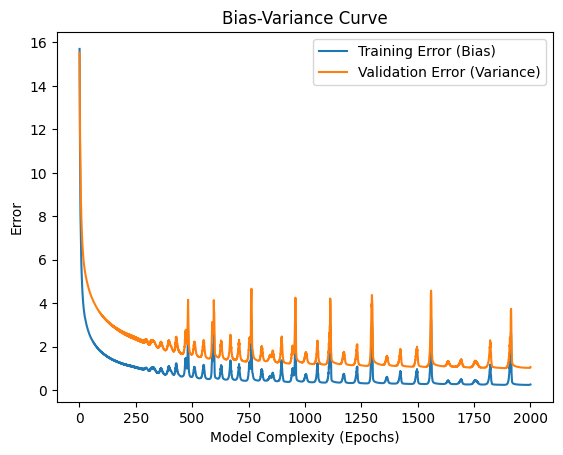

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve')
plt.legend()
plt.show()


#### With L1 (Lasso) Regularization

In [ ]:
def backward_prop_L1(self,Z, A, X, Y):
    lambd=0.01
    grads = {}
    m = X.shape[1]
    one_hot_Y = self.one_hot(Y)
    dZ = {}
    dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - one_hot_Y)
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * np.sign(self.params['W' + str(i)])
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads

In [ ]:
Model_mnist_L1=NeuralNetwork_1([784,400,10], 0.1, 2000)
Model_mnist_L1.backward_prop=backward_prop_L1.__get__(Model_mnist_L1, NeuralNetwork_1)
param_mnist,train_cost_list,test_cost_list=Model_mnist_L1.train(X_train, Y_train,X_test,Y_test)
test_accuracy=Model_mnist_L1.predict(X_test, Y_test, param_mnist)
print('Testing Accuracy: ',test_accuracy,'%')


 Iteration:  0     Training Accuracy:  10.62 %    Test Accuracy:  9.8 %

 Iteration:  20     Training Accuracy:  70.23 %    Test Accuracy:  55.03 %

 Iteration:  40     Training Accuracy:  75.0 %    Test Accuracy:  60.19 %

 Iteration:  60     Training Accuracy:  78.67 %    Test Accuracy:  64.16 %

 Iteration:  80     Training Accuracy:  80.0 %    Test Accuracy:  65.37 %

 Iteration:  100     Training Accuracy:  81.17 %    Test Accuracy:  66.63 %

 Iteration:  120     Training Accuracy:  81.89 %    Test Accuracy:  67.13 %

 Iteration:  140     Training Accuracy:  82.27 %    Test Accuracy:  67.34 %

 Iteration:  160     Training Accuracy:  82.59 %    Test Accuracy:  67.5 %

 Iteration:  180     Training Accuracy:  82.47 %    Test Accuracy:  67.26 %

 Iteration:  200     Training Accuracy:  82.3 %    Test Accuracy:  67.32 %

 Iteration:  220     Training Accuracy:  82.09 %    Test Accuracy:  67.34 %

 Iteration:  240     Training Accuracy:  82.38 %    Test Accuracy:  67.8 %

 Iteration:

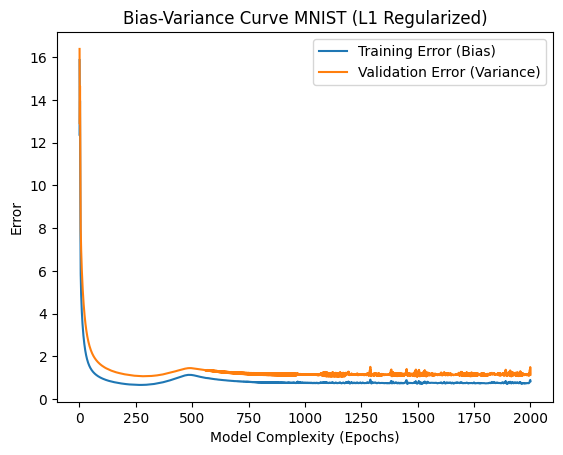

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve MNIST (L1 Regularized)')
plt.legend()
plt.show()

#### With L2(Ridge) Regularization

In [ ]:
def backward_prop_L2(self, Z, A, X, Y):
    lambd=0.1
    grads = {}
    m = X.shape[1]
    one_hot_Y = self.one_hot(Y)
    dZ = {}
    dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - one_hot_Y)
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads

In [ ]:
Model_mnist_L2=NeuralNetwork_1([784,400,10], 0.1, 2000)
Model_mnist_L2.backward_prop=backward_prop_L2.__get__(Model_mnist_L2, NeuralNetwork_1)
param_mnist,train_cost_list,test_cost_list=Model_mnist_L2.train(X_train, Y_train,X_test,Y_test)
test_accuracy=Model_mnist_L2.predict(X_test, Y_test, param_mnist)
print('\n Testing Accuracy: ',test_accuracy,'%')


 Iteration:  0     Training Accuracy:  8.36 %    Test Accuracy:  8.7 %

 Iteration:  20     Training Accuracy:  67.2 %    Test Accuracy:  52.2 %

 Iteration:  40     Training Accuracy:  73.25 %    Test Accuracy:  58.02 %

 Iteration:  60     Training Accuracy:  76.92 %    Test Accuracy:  61.78 %

 Iteration:  80     Training Accuracy:  79.91 %    Test Accuracy:  65.06 %

 Iteration:  100     Training Accuracy:  82.06 %    Test Accuracy:  67.64 %

 Iteration:  120     Training Accuracy:  83.48 %    Test Accuracy:  69.27 %

 Iteration:  140     Training Accuracy:  84.16 %    Test Accuracy:  69.97 %

 Iteration:  160     Training Accuracy:  84.49 %    Test Accuracy:  70.52 %

 Iteration:  180     Training Accuracy:  84.57 %    Test Accuracy:  70.62 %

 Iteration:  200     Training Accuracy:  84.57 %    Test Accuracy:  70.7 %

 Iteration:  220     Training Accuracy:  84.63 %    Test Accuracy:  70.73 %

 Iteration:  240     Training Accuracy:  84.63 %    Test Accuracy:  70.73 %

 Iteration

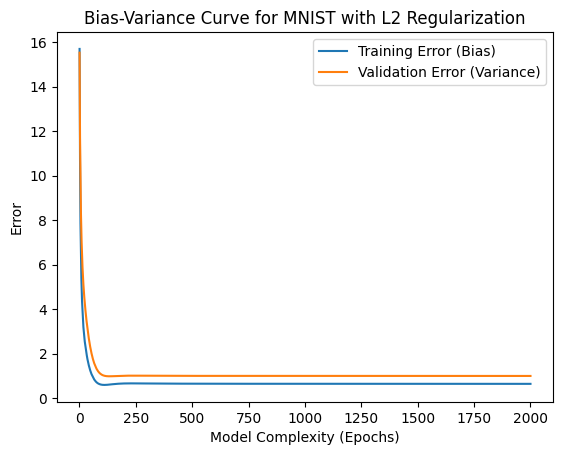

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve for MNIST with L2 Regularization')
plt.legend()
plt.show()

#### With Elatic Net Regularization

In [ ]:
def backward_prop_elastic(self, Z, A, X, Y):
    lambd1=0.01
    lambd2=0.01
    grads = {}
    m = X.shape[1]
    one_hot_Y = self.one_hot(Y)
    dZ = {}
    dZ['dZ' + str(self.N - 1)] =(A['A' + str(self.N - 1)] - one_hot_Y)
    for i in range(self.N - 1, 0, -1):
        grads['dW' + str(i)] = 1. / m * np.matmul(dZ['dZ' + str(i)], A['A' + str(i - 1)].T) + lambd1 * np.sign(self.params['W' + str(i)]) + lambd2 * self.params['W' + str(i)]
        grads['db' + str(i)] = 1. / m * np.sum(dZ['dZ' + str(i)], axis=1, keepdims=True)
        if i > 1:
            dZ['dZ' + str(i - 1)] = np.matmul(self.params['W' + str(i)].T, dZ['dZ' + str(i)]) * self.ReLU_deriv(Z['Z' + str(i - 1)])
    return grads

In [ ]:
Model_mnist_elastic=NeuralNetwork_1([784,200,10], 0.1, 2000)
Model_mnist_elastic.backward_prop=backward_prop_elastic.__get__(Model_mnist_elastic, NeuralNetwork_1)
param_mnist,train_cost_list,test_cost_list=Model_mnist_elastic.train(X_train, Y_train,X_test,Y_test)
test_accuracy=Model_mnist_elastic.predict(X_test, Y_test, param_mnist)
print('Testing Accuracy: ',test_accuracy,'%')


 Iteration:  0     Training Accuracy:  8.36 %    Test Accuracy:  8.7 %

 Iteration:  20     Training Accuracy:  67.11 %    Test Accuracy:  52.24 %

 Iteration:  40     Training Accuracy:  72.85 %    Test Accuracy:  58.05 %

 Iteration:  60     Training Accuracy:  75.62 %    Test Accuracy:  61.0 %

 Iteration:  80     Training Accuracy:  77.37 %    Test Accuracy:  62.88 %

 Iteration:  100     Training Accuracy:  78.51 %    Test Accuracy:  64.43 %

 Iteration:  120     Training Accuracy:  79.18 %    Test Accuracy:  65.38 %

 Iteration:  140     Training Accuracy:  80.0 %    Test Accuracy:  66.27 %

 Iteration:  160     Training Accuracy:  81.05 %    Test Accuracy:  67.09 %

 Iteration:  180     Training Accuracy:  82.19 %    Test Accuracy:  68.12 %

 Iteration:  200     Training Accuracy:  82.84 %    Test Accuracy:  69.11 %

 Iteration:  220     Training Accuracy:  82.82 %    Test Accuracy:  69.21 %

 Iteration:  240     Training Accuracy:  82.56 %    Test Accuracy:  68.45 %

 Iteratio

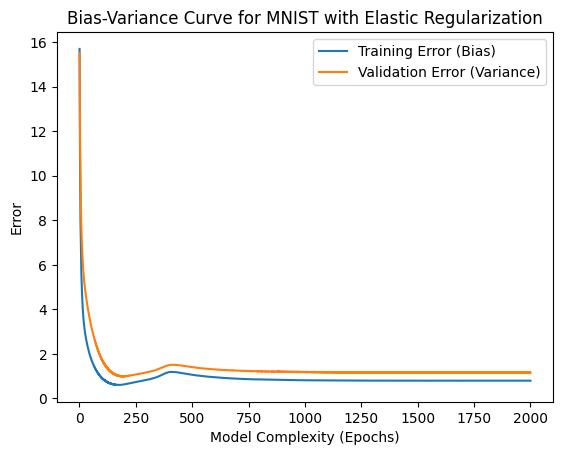

In [ ]:
training_errors = np.array(train_cost_list)
validation_errors = np.array(test_cost_list)

dataset_sizes = np.array(range(1,2001))

plt.plot(dataset_sizes, training_errors, label='Training Error (Bias)')
plt.plot(dataset_sizes, validation_errors, label='Validation Error (Variance)')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Error')
plt.title('Bias-Variance Curve for MNIST with Elastic Regularization')
plt.legend()
plt.show()

### One vs Rest Classifier

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

def log_reg(X, y, iterations, step_size):
    theta = np.zeros(X.shape[1])
    for i in range(iterations):
        z = np.dot(X, theta)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        theta -= step_size * gradient
    return theta

def predict_probs(X, theta):
    return sigmoid(np.dot(X, theta))

def predict(X, theta, thresh=0.5):
    return predict_probs(X, theta) >= thresh

def resample(data, n_samples):
    indices = np.random.randint(0, len(data), n_samples)
    return data[indices]

def one_vs_rest(X, y, iterations, step_size):
    W_all = []
    m = X.shape[0]
    n = X.shape[1]
    classes = np.unique(y)
    for c in classes:

        binary_y = np.where(y == c, 1, 0)

        data = np.hstack((X, binary_y.reshape(-1, 1)))

        majority = data[binary_y==0]
        minority = data[binary_y==1]

        minority_upsampled = resample(minority, len(majority))

        upsampled = np.vstack((majority, minority_upsampled))

        X_resampled = upsampled[:, :-1]
        y_resampled = upsampled[:, -1]

        theta_c = log_reg(X_resampled, y_resampled, iterations, step_size)
        W_all.append(theta_c)
    return np.array(W_all)

def train(X_train, y_train, iterations, step_size):
    W_all = one_vs_rest(X_train, y_train, iterations, step_size)
    return W_all

def test(X_test, W_all):
    predictions = []
    for theta in W_all:
        pred_probs = predict_probs(X_test, theta)
        predictions.append(pred_probs)
    return np.argmax(np.array(predictions).T, axis=1)

W_all = train(X_train.T, Y_train, 500, 0.05)
predictions = test(X_test.T, W_all)
accuracy = np.mean(predictions==Y_test)
print("Testing Accuracy: ",accuracy*100,"%")

Testing Accuracy:  63.59 %


# Q3(c) MNIST classification data using SVM

## Basic Setup

In [ ]:
import numpy as np
import matplotlib as plt

!pip install qpsolvers
from qpsolvers import solve_qp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Installing libsvm
!pip install libsvm-official
from libsvm.svmutil import *

  Preparing metadata (setup.py) ... done
  Created wheel for libsvm-official: filename=libsvm_official-3.32.0-cp310-cp310-linux_x86_64.whl size=123884 sha256=9d3bf0f7cf41b17a747ba6ad6a1e3b57e16f5de72a1c8033078e0d324a771c75
  Stored in directory: /root/.cache/pip/wheels/61/3b/1b/73bb4869517f96a26c82b47ccdb9ec48f12f4466de2371eff6
Successfully built libsvm-official


/usr/local/lib/python3.10/dist-packages/libsvm/svm.py:147: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def csr_to_problem_jit(l, x_val, x_ind, x_rowptr, prob_val, prob_ind, prob_rowptr, indx_start):


In [ ]:
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')


try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}


def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')


def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):
        download_list(next_level)
    else:
        traverse_dict(next_level)

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:24<00:00, 733.19KB/s] 


100%|██████████| 30/30 [00:00<00:00, 191.70KB/s]


100%|██████████| 3008/3008 [00:04<00:00, 751.20KB/s]


100%|██████████| 6/6 [00:00<00:00, 11837.17KB/s]

All dataset files downloaded!


In [ ]:
train_images = np.load('kmnist-train-imgs.npz')['arr_0'][:1000]/255
val_images= np.load('kmnist-train-imgs.npz')['arr_0'][1000:]/255
train_labels = np.load('kmnist-train-labels.npz')['arr_0'][:1000]
val_labels=np.load('kmnist-train-labels.npz')['arr_0'][1000:]
test_images = np.load('kmnist-test-imgs.npz')['arr_0']/255
test_labels = np.load('kmnist-test-labels.npz')['arr_0']
train_images.shape, train_labels.shape, val_images.shape,val_labels.shape, test_images.shape, test_labels.shape

((1000, 28, 28), (1000,), (59000, 28, 28), (59000,), (10000, 28, 28), (10000,))

In [ ]:
train_images=train_images.reshape(1000,784)
val_images= val_images.reshape(59000,784)
test_images=test_images.reshape(10000,784)
train_images.shape, test_images.shape, train_labels.shape,  test_labels.shape, val_images.shape,val_labels.shape,

((1000, 784), (10000, 784), (1000,), (10000,), (59000, 784), (59000,))

In [ ]:
def pca(data):
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    covariance = np.cov(centered_data.T)
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    sort_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sort_index]
    eigenvectors = eigenvectors[:, sort_index]
    k = 10
    principal_components = eigenvectors[:, :k]

    transformed_data = centered_data.dot(principal_components)
    return  transformed_data
train_images=pca(train_images)
val_images= pca(val_images)
test_images=pca(test_images)
train_images.shape, test_images.shape, train_labels.shape,  test_labels.shape, val_images.shape,val_labels.shape,

((1000, 10), (10000, 10), (1000,), (10000,), (59000, 10), (59000,))

In [ ]:
class MULTI_SVM():
  def __init__(self, X_train, X_test, y_train, y_test, input, C, degree=None, gamma=None):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.degree = degree
    self.gamma = gamma
    self.C = C
    self.input = input
    self.kernel = [self.linear_kernel, self.polynomial_kernel, self.rbf_kernel]
    self.n_classes = 10

  def linear_kernel(self, x1, x2):
    return np.dot(x1, x2.T)

  def polynomial_kernel(self, X1, X2):
    return (np.dot(X1, X2.T) + 1) ** self.degree

  def rbf_kernel(self, x1, x2):
    try:
      distance = np.linalg.norm(x1[:, None] - x2, axis=2) ** 2
    except:
      distance = np.linalg.norm(x1 - x2) ** 2
    return np.exp(-self.gamma * distance)

  def prediction(self):
    n_samples, n_features = self.X_train.shape
    y_pred = np.zeros(len(self.y_test))
    for class_index in range(self.n_classes):
      y_train_binary = np.where(self.y_train == class_index, 1, -1)

      K = self.kernel[self.input](self.X_train, self.X_train)
      P = np.outer(y_train_binary, y_train_binary) * K
      q = -np.ones(n_samples)
      G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
      h = np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C))
      A = self.y_train.reshape(1, -1).astype('d')
      b = np.zeros(1)
      mu = np.array(solve_qp(P, q, G, h ,A,b,solver='cvxopt')).flatten()

      support_vector_indices = np.where((mu > 1e-10) & (mu < self.C))
      X_support = self.X_train[support_vector_indices]
      y_support = self.y_train[support_vector_indices]
      mu_support = mu[support_vector_indices]

      w = np.sum(mu_support * y_support * X_support.T, axis=1)
      b = np.mean(y_support - np.dot(X_support, w))

      z = np.dot(self.X_test, w) + b
      class_y_pred = np.sign(np.array(z))
      y_pred[class_y_pred == 1] = class_index

    accuracy=np.mean(np.array(y_pred)== np.array(self.y_test))
    return accuracy * 100 , y_pred

## Hard SVM
---------------

#### Linear Kernel

In [ ]:
print("")
print("Validation Data")
print("")
model = MULTI_SVM(train_images, val_images, train_labels,  val_labels, input=0, C=100)
Accuracy , y_pred_Linear_HM_SVM = model.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data {Accuracy}%")
print(f"y_prediction 20 sample are {y_pred_Linear_HM_SVM[:20]}")
print("")
print("Test Data")
print("")
model = MULTI_SVM(train_images, test_images, train_labels,  test_labels, input=0, C=100)
Accuracy , y_pred_Linear_HM_SVM = model.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data {Accuracy}%")
print(f"y_prediction 20 sample are {y_pred_Linear_HM_SVM[:20]}")


Validation Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data 10.01551724137931%
y_prediction 20 sample are [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Test Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data 10.0%
y_prediction 20 sample are [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Polynomial Kernel

In [ ]:
degree_values = np.linspace(1,5,5)
results_shape = (len(degree_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(degree_values):
    accuracy, y_pred_Poly_HM_SVM = MULTI_SVM(train_images, val_images, train_labels,  val_labels, input=1, degree=param1_value, C=100).prediction()
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = degree_values[best_param1_idx]
print(f"Best parameters: Degree_of_polynomial = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM  with Polynomials _kernel is on validation data {results[best_param1_idx]}%")

print(f"y_prediction 20 sample are on validation data {y_pred_Poly_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(train_images, test_images, train_labels,  test_labels, input=1, degree=best_param1, C=100)
Accuracy , y_pred_poly_HM_SVM = result.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_HM_SVM[:20]}")

Best parameters: Degree_of_polynomial = 1.0
Accuracy for Hard MultiClass SVM  with Polynomials _kernel is on validation data 10.022033898305084%
y_prediction 20 sample are on validation data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TEST DATA

Accuracy for Hard MultiClass SVM  with Polynomial_kernel is on test_data 10.0%
y_prediction 20 sample are on test data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Rbf Kernel

In [ ]:
gamma_values = np.logspace(-3,1,5)
results_shape = (len(gamma_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    accuracy, y_pred_rbf_HM_SVM = MULTI_SVM(train_images, val_images, train_labels,  val_labels, input=2, gamma=param1_value, C=100).prediction()
    results[param1_idx] = accuracy

best_param1_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
print(f"Best parameters: gamma_value of Rbf kernel = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {y_pred_rbf_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(train_images, test_images, train_labels,  test_labels, input=2, gamma=best_param1, C=100)
Accuracy , y_pred_rbf_HM_SVM = result.prediction()
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_HM_SVM[:20]}")

Best parameters: gamma_value of Rbf kernel = 0.001
Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data 10.022033898305084%
y_prediction 20 sample are on validation data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TEST DATA

Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data 10.0%
y_prediction 20 sample are on test data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## SOFT SVM
---------------------------

#### Linear Kernel

In [ ]:
C_values = np.logspace(-3, 1, 5)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, y_pred_Linear_HM_SVM = MULTI_SVM(train_images, val_images, train_labels,  val_labels, input=0, C=param1_value).prediction()
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {y_pred_Linear_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(train_images, test_images, train_labels,  test_labels, input=0, C=best_param1)
Accuracy , y_pred_Linear_SM_SVM = result.prediction()
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_Linear_SM_SVM[:20]}")


Validation DATA

Best parameters: C_parameter = 0.001
Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data 10.01551724137931%
y_prediction 20 sample are on validation data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TEST DATA

Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data 10.0%
y_prediction 20 sample are on test data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Polynomial Kernel

In [ ]:
Degree_values = [1,2,3,4,5]
C_values = np.logspace(-3, 1, 5)
results_shape = (len(Degree_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(Degree_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = MULTI_SVM(train_images, val_images, train_labels,  val_labels, input=1, degree=param1_value ,C=param2_value).prediction()
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = Degree_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(train_images, test_images, train_labels,  test_labels, input=1, degree=best_param1, C=best_param2)
Accuracy , y_pred_poly_SM_SVM = result.prediction()
print(f"Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_SM_SVM[:20]}")



Validation DATA

Best parameters: Degree_of_polynomial = 3, C_value = 0.001
Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data 10.01896551724138%

TEST DATA

Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data 10.0%
y_prediction 20 sample are on test data [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


#### Rbf Kernel

In [ ]:
gamma_values = np.logspace(-4, 0, 5)
C_values = np.logspace(-3, 1, 5)
results_shape = (len(gamma_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy = MULTI_SVM(train_images, val_images, train_labels,  val_labels, input=2, gamma=param1_value ,C=param2_value).prediction()
      results[param1_idx, param2_idx] = accuracy[0]

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Gamma_value in Rbf Kernel = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print("")
print("TEST DATA")
print("")
result=MULTI_SVM(train_images, test_images, train_labels,  test_labels,input=2, gamma=best_param1, C=best_param2)
Accuracy , y_pred_rbf_SM_SVM = result.prediction()
print(f"Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_SM_SVM[:20]}")


Validation DATA

Best parameters: Gamma_value in Rbf Kernel = 0.0001, C_value = 0.001
Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data 10.022033898305084%

TEST DATA

Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data 10.0%
y_prediction 20 sample are on test data [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Hard SVM using LibSVm

In [ ]:
class HARD_SVM_Multiclass():
  def __init__(self,X_multi_train,X_multi_test,y_multi_train,y_multi_test):
    self.X_multi_train=X_multi_train
    self.X_multi_test=X_multi_test
    self.y_multi_train=y_multi_train
    self.y_multi_test=y_multi_test
    return

  def Linear_kernal_multiClass(self):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 0 -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Poly_kernal_multiClass(self, degree):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 1 -d {int(degree)} -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Rbf_kernal_multiClass(self, gamma):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 2 -g {gamma} -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Sigmoid_kernal_multiClass(self):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-t 3 -b 1 -c 100")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)

    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

#### Linear Kernel

In [ ]:
model = HARD_SVM_Multiclass(train_images, val_images, train_labels, val_labels)
accuracy , Y_pred_Linear_HM_SVM = model.Linear_kernal_multiClass()

model = HARD_SVM_Multiclass(train_images, test_images, train_labels, test_labels)
Accuracy , y_pred_Linear_HM_SVM = model.Linear_kernal_multiClass()


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation Data")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data {accuracy}%")
print(f"y_prediction 20 sample are {Y_pred_Linear_HM_SVM[:20]}")
print("")
print("Test Data")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data {Accuracy}%")
print(f"y_prediction 20 sample are {y_pred_Linear_HM_SVM[:20]}")


Validation Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on validation data 5.428813559322034%
y_prediction 20 sample are [7 8 4 7 6 5 3 6 4 5 3 5 3 7 3 0 5 8 5 4]

Test Data

Accuracy for Hard MultiClass SVM  with Linear_kernel is on test data 9.36%
y_prediction 20 sample are [6 9 7 2 9 6 4 5 5 9 5 9 4 4 7 6 9 5 5 9]


#### Polynomail Kernel

In [ ]:
degree_values = np.linspace(1,5,5)
results_shape = (len(degree_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(degree_values):
    accuracy, Y_pred_Poly_HM_SVM = HARD_SVM_Multiclass(train_images, val_images, train_labels, val_labels).Poly_kernal_multiClass(degree=param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = degree_values[best_param1_idx]

result=HARD_SVM_Multiclass(train_images, test_images, train_labels, test_labels)
Accuracy , y_pred_poly_HM_SVM = result.Poly_kernal_multiClass(degree=best_param1)


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation Data")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM with Polynomials _kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_Poly_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Hard MultiClass SVM with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_HM_SVM[:20]}")


Validation Data

Best parameters: Degree_of_polynomial = 2.0
Accuracy for Hard MultiClass SVM with Polynomials _kernel is on validation data 15.472881355932202%
y_prediction 20 sample are on validation data [2 7 2 7 6 7 2 2 2 3 2 3 3 8 2 0 4 2 2 0]

TEST DATA

Accuracy for Hard MultiClass SVM with Polynomial_kernel is on test_data 13.459999999999999%
y_prediction 20 sample are on test data [8 2 0 4 3 6 4 2 2 1 1 3 3 5 5 2 4 0 5 3]


#### RBF Kernel

In [ ]:
gamma_values = np.logspace(-3, 1, 5)
results_shape = (len(gamma_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    accuracy, Y_pred_rbf_HM_SVM = HARD_SVM_Multiclass(train_images, val_images, train_labels, val_labels).Rbf_kernal_multiClass(gamma=param1_value)
    results[param1_idx] = accuracy

best_param1_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]

result=HARD_SVM_Multiclass(train_images, test_images, train_labels, test_labels)
Accuracy , y_pred_rbf_HM_SVM = result.Rbf_kernal_multiClass(gamma=best_param1)


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation Data")
print("")
print(f"Best parameters: gamma_value of Rbf kernel = {best_param1}")
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_rbf_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_HM_SVM[:20]}")


Validation Data

Best parameters: gamma_value of Rbf kernel = 10.0
Accuracy for Hard MultiClass SVM  with Rbf_kernel is on validation data 9.979661016949153%
y_prediction 20 sample are on validation data [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]

TEST DATA

Accuracy for Hard MultiClass SVM  with Rbf_kernel is on test_data 10.0%
y_prediction 20 sample are on test data [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


## Soft SVM using LibSvm

In [ ]:
class SOFT_SVM_Multiclass():
  def __init__(self,X_multi_train,X_multi_test,y_multi_train,y_multi_test):
    self.X_multi_train=X_multi_train
    self.X_multi_test=X_multi_test
    self.y_multi_train=y_multi_train
    self.y_multi_test=y_multi_test
    return

  def Linear_kernal_multiClass(self, C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C} -t 0 -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Poly_kernal_multiClass(self,degree,C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C}  -t 1 -d {int(degree)}  -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Rbf_kernal_multiClass(self,gamma,C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C}  -t 2 -g {gamma}  -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

  def Sigmoid_kernal_multiClass(self, C):
    prob_estimates = []
    models = []
    for class_idx in range(10):
        binary_labels = np.where(self.y_multi_train == class_idx, 1, -1)
        model = svm_train(binary_labels, self.X_multi_train, f"-c {C} -t 3 -b 1")
        models.append(model)
    for new_data_point in self.X_multi_test:
        prob_per_class = []
        for model in models:
            _, _, prob= svm_predict([0], [new_data_point.tolist()], model,"-b 1")
            prob_per_class.append(prob[0][0])
        prob_estimates.append(prob_per_class)
    predicted_class = np.argmax(prob_estimates, axis=1)
    accuracy=np.mean(np.array(predicted_class)== np.array(self.y_multi_test))
    return accuracy*100, predicted_class

#### Linear Kernel

In [ ]:
C_values = np.logspace(-2, 1, 5)
results_shape = (len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(C_values):
    accuracy, Y_pred_Linear_HM_SVM = SOFT_SVM_Multiclass(train_images, val_images, train_labels, val_labels).Linear_kernal_multiClass(C=param1_value)
    results[param1_idx] = accuracy

best_param1_idx= np.unravel_index(np.argmax(results), results_shape)
best_param1 = C_values[best_param1_idx]

result=SOFT_SVM_Multiclass(train_images, test_images, train_labels, test_labels)
Accuracy , y_pred_Linear_SM_SVM = result.Linear_kernal_multiClass(C=best_param1)

Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation DATA")
print("")
print(f"Best parameters: C_parameter = {best_param1}")
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data {results[best_param1_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_Linear_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_Linear_SM_SVM[:20]}")


Validation DATA

Best parameters: C_parameter = 0.05623413251903491
Accuracy for Soft MultiClass SVM  with Linear_kernel is on validation data 6.330508474576272%
y_prediction 20 sample are on validation data [7 8 4 7 6 5 3 6 4 3 3 5 3 7 3 0 5 8 5 4]

TEST DATA

Accuracy for Soft MultiClass SVM  with Linear_kernel is on test_data 9.379999999999999%
y_prediction 20 sample are on test data [6 9 7 2 9 6 4 2 5 9 5 9 4 4 7 2 9 3 5 9]


#### Polynomail Kernel

In [ ]:
Degree_values = [1,2,3]
C_values = np.logspace(-2, 1, 5)
results_shape = (len(Degree_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(Degree_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy, Y_pred_poly_HM_SVM = SOFT_SVM_Multiclass(train_images, val_images, train_labels, val_labels).Poly_kernal_multiClass(degree=param1_value ,C=param2_value)
      results[param1_idx, param2_idx] = accuracy

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = Degree_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]

result=SOFT_SVM_Multiclass(train_images, test_images, train_labels, test_labels)
Accuracy , y_pred_poly_SM_SVM = result.Poly_kernal_multiClass(degree=best_param1, C=best_param2)

Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Degree_of_polynomial = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_poly_HM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_poly_SM_SVM[:20]}")


Validation DATA

Best parameters: Degree_of_polynomial = 2, C_value = 10.0
Accuracy for Soft MultiClass SVM  with Ploynomail kernel with GridSearch is on validation data 16.25593220338983%
y_prediction 20 sample are on validation data [7 7 1 7 6 7 1 7 8 3 7 3 3 8 7 0 4 2 6 1]

TEST DATA

Accuracy for Soft MultiClass SVM  with Polynomial_kernel is on test_data 14.12%
y_prediction 20 sample are on test data [2 2 8 4 3 6 4 2 2 1 1 3 3 5 5 2 4 6 5 3]


#### Rbf Kernel

In [ ]:
gamma_values = np.logspace(-3, 1, 5)
C_values = np.logspace(-2, 1, 5)
results_shape = (len(gamma_values), len(C_values))
results = np.zeros(results_shape, dtype=np.float64)

for param1_idx, param1_value in enumerate(gamma_values):
    for param2_idx, param2_value in enumerate(C_values):
      accuracy, Y_pred_rbf_SM_SVM  = SOFT_SVM_Multiclass(train_images, val_images, train_labels, val_labels).Rbf_kernal_multiClass(gamma=param1_value ,C=param2_value)
      results[param1_idx, param2_idx] = accuracy

best_param1_idx, best_param2_idx = np.unravel_index(np.argmax(results), results_shape)
best_param1 = gamma_values[best_param1_idx]
best_param2 = C_values[best_param2_idx]

result=SOFT_SVM_Multiclass(train_images, test_images, train_labels, test_labels)
Accuracy , y_pred_rbf_SM_SVM = result.Rbf_kernal_multiClass(gamma=best_param1, C=best_param2)


Streaming output truncated to the last 5000 lines.
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (classification)
Accuracy = 0% (0/1) (cla

In [ ]:
print("")
print("Validation DATA")
print("")
print(f"Best parameters: Gamma_value in Rbf Kernel = {best_param1}, C_value = {best_param2}")
print(f"Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data {results[best_param1_idx, best_param2_idx]}%")
print(f"y_prediction 20 sample are on validation data {Y_pred_rbf_SM_SVM[:20]}")
print("")
print("TEST DATA")
print("")
print(f"Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data {Accuracy}%")
print(f"y_prediction 20 sample are on test data {y_pred_rbf_SM_SVM[:20]}")


Validation DATA

Best parameters: Gamma_value in Rbf Kernel = 10.0, C_value = 0.01
Accuracy for Soft MultiClass SVM  with Rbf kernel with GridSearch is on validation data 9.981355932203389%
y_prediction 20 sample are on validation data [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]

TEST DATA

Accuracy for Soft MultiClass SVM  with Rbf_kernel is on test_data 10.0%
y_prediction 20 sample are on test data [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


# **Q3(c) MNIST Classification Using CNN**#

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the image data
image_data = np.load('kmnist/kmnist-train-imgs.npz')

X_train = image_data['arr_0']

label_data = np.load('kmnist/kmnist-train-labels.npz')

y_train = label_data['arr_0']

X_train = X_train.astype('float32') / 255.0

num_classes = 10
y_train = np.eye(num_classes)[y_train]


In [ ]:
import numpy as np

class Convolution():
    def __init__(self, n_filters, f_size):
        self.nf = n_filters
        self.fs = f_size
        self.cf = np.random.randn(n_filters, f_size, f_size)

    def img_reg(self, img):
        self.img = img
        h, w = img.shape
        for i in range(h - self.fs + 1):
            for j in range(w - self.fs + 1):
                yield img[i:i+self.fs, j:j+self.fs], i, j

    def forward(self, img):
        h, w = img.shape
        out = np.zeros((h-self.fs+1, w-self.fs+1, self.nf))
        for patch, i, j in self.img_reg(img):
            out[i,j] = np.sum(patch*self.cf, axis=(1,2))
        return out

    def backward(self, dL_dout, lr):
        dL_dF = np.zeros(self.cf.shape)
        for patch, i, j in self.img_reg(self.img):
            for k in range(self.nf):
                dL_dF[k] += patch * dL_dout[i, j, k]
        self.cf -= lr * dL_dF
        return dL_dF


In [ ]:
class MaxPool():
    def __init__(self, k):
        self.k = k

    def img_reg(self, img):
        nh, nw = img.shape[0] // self.k, img.shape[1] // self.k
        self.img = img
        for i in range(nh):
            for j in range(nw):
                patch = img[(i * self.k): (i * self.k + self.k),
                            (j * self.k): (j * self.k + self.k)]
                yield patch, i, j

    def forward(self, img):
        h, w, f = img.shape
        out = np.zeros((h // self.k, w // self.k, f))
        for patch, i, j in self.img_reg(img):
            out[i, j] = np.amax(patch, axis=(0, 1))
        return out

    def backward(self, dL_dout):
        dL_dpool = np.zeros_like(self.img)
        for patch, i, j in self.img_reg(self.img):
            h, w, f = patch.shape
            max_val = np.amax(patch, axis=(0, 1))

            for i1 in range(h):
                for j1 in range(w):
                    for k in range(f):
                        if patch[i1, j1, k] == max_val[k]:
                            dL_dpool[i * self.k + i1, j * self.k + j1, k] = dL_dout[i, j, k]
        return dL_dpool


In [ ]:
class Softmax():

    def __init__(self, out, input):
        self.W = np.random.randn(out,input)
        self.b = np.zeros((out,))

    def softmax(self, x):
        expX = np.exp(x)
        return expX/np.sum(expX, axis = 0)

    def forward(self, input):
        self.f = input
        Z = np.dot(self.W,input) + self.b
        a = self.softmax(Z)
        return a

    def backward(self, dz1, lr):
        dw1 = np.dot(dz1.reshape(-1,1), self.f.reshape(1,-1))
        db1 = dz1
        df1 = np.dot(self.W.T, dz1.reshape(-1,1))
        self.W -= lr * dw1
        self.b -= lr * db1
        return df1




In [ ]:
#Forward and Backward pass testing

#Forward Pass
conv = Convolution(16, 3)
output_conv = conv.forward(X_train[0])
pool = MaxPool(2)
output_pool = pool.forward(output_conv)
output_flatten = output_pool.flatten()
soft = Softmax(10, output_flatten.shape[0])
a = soft.forward(output_flatten)

#Backward Pass
dz1 = a - y_train[0]
df1 = soft.backward(dz1, 0.01)
dp1 = df1.reshape(output_pool.shape)
back_pool = pool.backward(dp1)
back_conv = conv.backward(back_pool, 0.01)

In [ ]:
class CNN:
    def __init__(self, conv_layer, pool_layer, softmax_layer):
        self.conv = conv_layer
        self.pool = pool_layer
        self.softmax = softmax_layer

    def forward(self, input):
        self.conv_output = self.conv.forward(input)
        self.pool_output = self.pool.forward(self.conv_output)
        self.flat_output = self.pool_output.flatten()
        self.output = self.softmax.forward(self.flat_output)
        return self.output

    def backward(self, dL_dout, learning_rate):
        dL_dflat = self.softmax.backward(dL_dout, learning_rate)
        dL_dpool = dL_dflat.reshape(self.pool_output.shape)
        dL_dconv = self.pool.backward(dL_dpool)
        self.conv.backward(dL_dconv, learning_rate)

    def train(self, X_train, y_train, num_epochs):
        num_iteration = 60000
        for j in range(num_epochs):
            count = 0

            print(f"Epoch{j+1}")
            count = 0
            for i in range(num_iteration):

                output = self.forward(X_train[i])
                pred = np.argmax(output)
                true = np.argmax(y_train[i])

                if pred == true:
                    count += 1

                dL_dout = output - y_train[i]
                self.backward(dL_dout, 0.01)

                if i%10000 == 0 and i!= 0 :

                    print(f"Batch {i // 10000} - Accuracy: {(count/10000)*100:.2f}%")
                    count = 0

    def test(self, X_test, Y_test):
        count = 0
        for i in range(10000):
            out1 = self.conv.forward(X_test[i])
            out2 = self.pool.forward(out1)
            out3 = out2.flatten()
            out4 = self.softmax.forward(out3)

            pred = np.argmax(out4)
            true = np.argmax(y_test[i])
            if pred == true:
                count += 1
        print(f'Test Accuracy {count/10000}')



In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
# Define the layers and parameters

conv = Convolution(16, 3)
pool = MaxPool(2)
softmax = Softmax(10, output_flatten.shape[0])
cnn_model = CNN(conv, pool, softmax)


cnn_model.train(X_train, y_train, num_epochs=3)

Epoch1
Batch 1 - Accuracy: 57.51%
Batch 2 - Accuracy: 67.76%
Batch 3 - Accuracy: 70.22%
Batch 4 - Accuracy: 72.27%
Batch 5 - Accuracy: 73.50%
Epoch2
Batch 1 - Accuracy: 76.65%
Batch 2 - Accuracy: 76.57%
Batch 3 - Accuracy: 76.99%
Batch 4 - Accuracy: 78.51%
Batch 5 - Accuracy: 78.69%
Epoch3
Batch 1 - Accuracy: 80.57%
Batch 2 - Accuracy: 80.43%
Batch 3 - Accuracy: 80.69%
Batch 4 - Accuracy: 82.22%
Batch 5 - Accuracy: 81.96%


In [ ]:
cnn_model.test(X_test, y_test)

Test Accuracy 0.711


In [ ]:
def test(X_test, Y_test):
        count = 0
        for i in range(10000):
            out1 = cnn_model.conv.forward(X_test[i])
            out2 = cnn_model.pool.forward(out1)
            out3 = out2.flatten()
            out4 = cnn_model.softmax.forward(out3)

            pred = np.argmax(out4)
            true = np.argmax(y_test[i])
            if pred == true:
                count += 1
        print(f'Test Accuracy {(count/10000)*100}')

In [ ]:
# Load the image data
image_data = np.load('kmnist/kmnist-test-imgs.npz')

X_test = image_data['arr_0']
X_test = X_test.astype('float32') / 255.0

label_data = np.load('kmnist/kmnist-test-labels.npz')

y_test = label_data['arr_0']


num_classes = 10
y_test = np.eye(num_classes)[y_test]

In [ ]:
test(X_test, y_test)


Test Accuracy 71.1


In [ ]:
# Define the layers and parameters

conv = Convolution(16, 3)
pool = MaxPool(2)
softmax = Softmax(10, output_flatten.shape[0])
cnn_model = CNN(conv, pool, softmax)


cnn_model.train(X_train, y_train, num_epochs=3)

Epoch1
Batch 1 - Accuracy: 57.51%
Batch 2 - Accuracy: 67.76%
Batch 3 - Accuracy: 70.22%
Batch 4 - Accuracy: 72.27%
Batch 5 - Accuracy: 73.50%
Epoch2
Batch 1 - Accuracy: 76.65%
Batch 2 - Accuracy: 76.57%
Batch 3 - Accuracy: 76.99%
Batch 4 - Accuracy: 78.51%
Batch 5 - Accuracy: 78.69%
Epoch3
Batch 1 - Accuracy: 80.57%
Batch 2 - Accuracy: 80.43%
Batch 3 - Accuracy: 80.69%
Batch 4 - Accuracy: 82.22%
Batch 5 - Accuracy: 81.96%


Epoch1
Batch 1 - Accuracy: 57.51%
Batch 2 - Accuracy: 67.76%
Batch 3 - Accuracy: 70.22%
Batch 4 - Accuracy: 72.27%
Batch 5 - Accuracy: 73.50%
Epoch2
Batch 1 - Accuracy: 76.65%
Batch 2 - Accuracy: 76.57%
Batch 3 - Accuracy: 76.99%
Batch 4 - Accuracy: 78.51%
Batch 5 - Accuracy: 78.69%
Epoch3
Batch 1 - Accuracy: 80.57%
Batch 2 - Accuracy: 80.43%
Batch 3 - Accuracy: 80.69%
Batch 4 - Accuracy: 82.22%
Batch 5 - Accuracy: 81.96%


# Comparison of Models in MNIST

In [16]:
print("Compare the performance of each of the models:\n")
print("Model                          | Accuracy")
print("--------------------------------|-------------------------------------------------")
print("Logistic Regression            | 63.59%")
print("\nSVM with Gaussian Kernel       | 10.022% (with only 1000 data points because hard to train complex image dataset with SVMs)")
print("\nMLPs                           | Without Regularization:            With L2 Regularization:")
print("                               | Best Train accuracy: 93.54%          Best Train accuracy: 84.35%")
print("                               | Best Test Accuracy: 78.45%           Best Test Accuracy: 70.16%")
print("\nCNNS                           | Train accuracy: 81.96%, Test accuracy: 71.1%\n\n\n\n")


print("-->Logistic Regression is a simple and fast model, but it performed well on complex MNIST because it assumes \na linear decision boundary. \n\n-->SVM with Gaussian Kernel can model complex, non-linear decision boundaries, and they are performing well on \nimage datasets. However, they are slow on training large datasets.\n \n-->MLPs can model non-linear decision boundaries and they can learn features automatically from the data.\n However, they are prone to overfitting if not properly regularized.\n \n-->CNNs are specifically designed for image data. They can learn hierarchical features automatically \nfrom the data and often provide the best performance on image datasets. However, they require a lot of\n computational resources to train. ")

Compare the performance of each of the models:

Model                          | Accuracy
--------------------------------|-------------------------------------------------
Logistic Regression            | 63.59%

SVM with Gaussian Kernel       | 10.022% (with only 1000 data points because hard to train complex image dataset with SVMs)

MLPs                           | Without Regularization:            With L2 Regularization:
                               | Best Train accuracy: 93.54%          Best Train accuracy: 84.35%
                               | Best Test Accuracy: 78.45%           Best Test Accuracy: 70.16%

CNNS                           | Train accuracy: 81.96%, Test accuracy: 71.1%




-->Logistic Regression is a simple and fast model, but it performed well on complex MNIST because it assumes 
a linear decision boundary. 

-->SVM with Gaussian Kernel can model complex, non-linear decision boundaries, and they are performing well on 
image datasets. However, they are slow 